# Projected likelihood of future ice-free periods for the Arctic and Antarctic, and  for Arctic Shipping routes

## User question
When could we expect sea-ice-free conditions in the Arctic and Antarctic, and along the Arctic shipping routes?

## Methods
As well as the historical experiment we consider the sea ice concentration (SIC) and extent from the following projection experiments, chosen because they had a sufficiently large number of models that provided SIC outputs:
- `ssp_1_2_6` (full description at [es-doc.org](https://view.es-doc.org/?renderMethod=name&project=cmip6&type=cim.2.designing.NumericalExperiment&client=esdoc-url-rewrite&name=ssp126))
- `ssp2_4_5` (full description at [es-doc.org](https://view.es-doc.org/?renderMethod=name&project=cmip6&type=cim.2.designing.NumericalExperiment&client=esdoc-url-rewrite&name=ssp245))
- `ssp3_7_0` (full description at [es-doc.org](https://view.es-doc.org/?renderMethod=name&project=cmip6&type=cim.2.designing.NumericalExperiment&client=esdoc-url-rewrite&name=ssp370))
- `ssp5_8_5` (full description at [es-doc.org](https://view.es-doc.org/?renderMethod=name&project=cmip6&type=cim.2.designing.NumericalExperiment&client=esdoc-url-rewrite&name=ssp585))

The experiments are ordered by expected warming with `ssp_1_2_6` giving the least warming (this is a kind of "best case" warming scenario) and `ssp5_8_5` giving high warming. The last two numbers give the radiative forcing reached in 2100 in W/m$^2$ - e.g `ssp5_8_5` reaches 8.5 W/m$^2$ by the end of the century.

We calculate the sea ice diagnostics extent and area for the Arctic and Antarctica, comparing the historical results to satellite observations, and show some maps to show projected changes in the spatial distribution of SIC. We also look at the projected ice coverage in two Arctic shipping routes - the Transpolar Sea Route (TSR) and the Northern |Sea Route (NSR). For these we use sea-ice/open-water classifications (SIC > 30%) from the CMIP6 projections are used to estimate the likelihood of them being sea-ice-free in the future. This is presented visually in charts with year on the y-axis and month on the x-axis and a colorbar showing the likelihood (fraction of models projecting ice-free conditions).

## Assessment
Depending on the warming scenario, the Arctic itself has varying chances of being ice-free in the summer, as does the NSR. The probability of the TSR being clear is lower in the summer than that of the NSR. However, for warming scenarios with more warming, the chances of the TSR being clear during some winter months (eg December) are higher than for the NSR.

There is also some chance of the sea around Antarctica being ice-free, but this is smaller than in the Arctic.

## Code

### Import libraries

In [1]:
import datetime
import warnings
import calendar
import numpy as np
import pandas as pd
from collections import defaultdict
from cmocean import cm

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot

plt.style.use("seaborn-v0_8-notebook")
warnings.filterwarnings("ignore", module="cf_xarray")

In [2]:
import os
os.environ["CDSAPI_RC"] = "/data/wp4/williams_timothy/.cdsapirc"

### Set parameters

In [3]:
# Time
year_start = 1850
year_stop = 2100
assert year_start >= 1850 and year_stop <= 2100
assert not year_start % 10

# Select masks
sea_masks = [
    "arctic",
    "antarctic",
    "transpolar_shipping_route",
    "northern_sea_shipping_route",
]
assert set(sea_masks) <= {
    "arctic",
    "antarctic",
    "transpolar_shipping_route",
    "northern_sea_shipping_route",
}

# Sea Ice Concentration Threshold
sic_threshold = 30  # %

# Models
experiments = [
    "historical",
    "ssp1_2_6",
    "ssp2_4_5",
    "ssp3_7_0",
    "ssp5_8_5"
]
assert set(experiments) & {
    "historical",
    "ssp1_1_9",
    "ssp1_2_6",
    "ssp2_4_5",
    "ssp3_7_0",
    "ssp4_3_4",
    "ssp4_6_0",
    "ssp5_8_5",
}

### Define models for each experiment

In [4]:
models_dict = {
    "historical": [
        "access_cm2",
        "access_esm1_5",
        "cams_csm1_0",
        "canesm5",
        "canesm5_canoe",
        "cmcc_cm2_hr4",
        "cmcc_cm2_sr5",
        "cmcc_esm2",
        "cnrm_cm6_1",
        "cnrm_cm6_1_hr",
        "cnrm_esm2_1",
        "e3sm_1_0",
        "e3sm_1_1",
        "e3sm_1_1_eca",
        "ec_earth3_aerchem",
        "ec_earth3_cc",
        "ec_earth3_veg_lr",
        "fgoals_f3_l",
        "giss_e2_1_h",
        "hadgem3_gc31_ll",
        "hadgem3_gc31_mm",
        "inm_cm4_8",
        "inm_cm5_0",
        "ipsl_cm5a2_inca",
        "ipsl_cm6a_lr",
        "miroc6",
        "miroc_es2l",
        "mpi_esm1_2_hr",
        "mpi_esm1_2_lr",
        "mri_esm2_0",
        "nesm3",
        "norcpm1",
        "taiesm1",
        "ukesm1_0_ll",
    ],
    "ssp1_1_9": [
        "canesm5",
        "ec_earth3",
        "ec_earth3_veg",
        "ec_earth3_veg_lr",
        "fgoals_g3",
        "gfdl_esm4",
        "ipsl_cm6a_lr",
        "miroc6",
        "miroc_es2l",
        "mri_esm2_0",
        "ukesm1_0_ll",
    ],
    "ssp1_2_6": [
        "access_cm2",
        "canesm5_canoe",
        "cmcc_cm2_sr5",
        "cmcc_esm2",
        "cnrm_cm6_1",
        "cnrm_cm6_1_hr",
        "ec_earth3_veg_lr",
        "fgoals_f3_l",
        "fgoals_g3",
        "gfdl_esm4",
        "hadgem3_gc31_ll",
        "hadgem3_gc31_mm",
        "inm_cm4_8",
        "inm_cm5_0",
        "ipsl_cm5a2_inca",
        "ipsl_cm6a_lr",
        "miroc6",
        "miroc_es2l",
        "mpi_esm1_2_lr",
        "mri_esm2_0",
        "nesm3",
        "taiesm1",
        "ukesm1_0_ll",
    ],
    "ssp2_4_5": [
        "access_cm2",
        "canesm5_canoe",
        "cmcc_cm2_sr5",
        "cmcc_esm2",
        "cnrm_cm6_1",
        "cnrm_cm6_1_hr",
        "cnrm_esm2_1",
        "ec_earth3_cc",
        "ec_earth3_veg_lr",
        "fgoals_f3_l",
        "fgoals_g3",
        "hadgem3_gc31_ll",
        "inm_cm4_8",
        "inm_cm5_0",
        "ipsl_cm6a_lr",
        "miroc6",
        "miroc_es2l",
        "mpi_esm1_2_lr",
        "mri_esm2_0",
        "nesm3",
        "taiesm1",
        "ukesm1_0_ll",
    ],
    "ssp3_7_0": [
        "access_cm2",
        "canesm5",
        "canesm5_canoe",
        "cmcc_cm2_sr5",
        "cnrm_cm6_1",
        "cnrm_cm6_1_hr",
        "ec_earth3_aerchem",
        "ec_earth3_veg_lr",
        "fgoals_f3_l",
        "fgoals_g3",
        "gfdl_esm4",
        "inm_cm4_8",
        "inm_cm5_0",
        "ipsl_cm5a2_inca",
        "ipsl_cm6a_lr",
        "miroc6",
        "miroc_es2l",
        "mpi_esm1_2_lr",
        "mri_esm2_0",
        "taiesm1",
        "ukesm1_0_ll",
    ],
    "ssp4_3_4": [
        "canesm5",
        "ec_earth3",
        "fgoals_g3",
        "ipsl_cm6a_lr",
        "miroc6",
        "mri_esm2_0",
        "ukesm1_0_ll",
    ],
    "ssp4_6_0": [
        "canesm5",
        "fgoals_g3",
        "ipsl_cm6a_lr",
        "miroc6",
        "mri_esm2_0",
    ],
    "ssp5_8_5": [
        "access_cm2",
        "canesm5_canoe",
        "cmcc_cm2_sr5",
        "cmcc_esm2",
        "cnrm_cm6_1",
        "cnrm_cm6_1_hr",
        "e3sm_1_1",
        "ec_earth3_cc",
        "ec_earth3_veg_lr",
        "fgoals_f3_l",
        "fgoals_g3",
        "gfdl_esm4",
        "hadgem3_gc31_ll",
        "hadgem3_gc31_mm",
        "inm_cm4_8",
        "inm_cm5_0",
        "ipsl_cm6a_lr",
        "miroc6",
        "mpi_esm1_2_lr",
        "mri_esm2_0",
        "nesm3",
        "ukesm1_0_ll",
    ],
}

### Define requests for CDS data

In [5]:
all_months = [f"{month:02d}" for month in range(1, 13)]

request_cmip6_historical = (
    "projections-cmip6",
    {
        "format": "zip",
        "temporal_resolution": "monthly",
        "experiment": "historical",
        "variable": "sea_ice_area_percentage_on_ocean_grid",
        "year": [
            str(year) for year in range(max(year_start, 1850), min(year_stop, 2014) + 1)
        ],
        "month": all_months,
    },
)

request_cmip6_projections = (
    "projections-cmip6",
    {
        "format": "zip",
        "temporal_resolution": "monthly",
        "experiment": "historical",
        "variable": "sea_ice_area_percentage_on_ocean_grid",
        "year": [
            str(year) for year in range(max(year_start, 2015), min(year_stop, 2100) + 1)
        ],
        "month": all_months,
    },
)

request_eumetsat = (
    "satellite-sea-ice-concentration",
    download.update_request_date(
        {
            "cdr_type": "cdr",
            "origin": "eumetsat_osi_saf",
            "variable": "all",
            "version": "v2",
        },
        start=f"{max(year_start, 1979)}-01",
        stop=f"{min(year_stop, 2015)}-12",
        stringify_dates=True,
    ),
)

request_esa = (
    "satellite-sea-ice-concentration",
    download.update_request_date(
        {
            "cdr_type": "cdr",
            "origin": "esa_cci",
            "variable": "all",
            "version": "v2",
        },
        start=f"{max(year_start, 2002)}-01",
        stop=f"{min(year_stop, 2017)}-12",
        stringify_dates=True,
    ),
)

### Define function to transform data before it is cached

#### Functions to be run at download time
The main function is `compute_interpolated_sea_ice_extent_and_area` - sea ice extent and area will be downloaded and saved to disk.

In [6]:
def apply_sea_mask(obj, sea_mask):
    lon = obj["longitude"].where(obj["longitude"] >= 0, obj["longitude"] + 360)
    lat = obj["latitude"]

    if sea_mask == "transpolar_shipping_route":
        limits = {
            "Chuckchi_Sea": {
                "lon_min": 180.0,
                "lon_max": 200.0,
                "lat_min": 66.0,
                "lat_max": 90,
            },
            "Siberian_Laptev_Kara_Seas": {
                "lon_min": 35.0,
                "lon_max": 180.0,
                "lat_min": 83.0,
                "lat_max": 90,
            },
            "Barents_Sea": {
                "lon_min": 5.0,
                "lon_max": 35.0,
                "lat_min": 68.0,
                "lat_max": 90,
            },
        }
    elif sea_mask == "northern_sea_shipping_route":
        limits = {
            "Chuckchi_Sea": {
                "lon_min": 177.0,
                "lon_max": 192.0,
                "lat_min": 66.0,
            },
            "Siberian_Sea": {
                "lon_min": 141.0,
                "lon_max": 177.0,
                "lat_min": 68.0,
            },
            "Laptev_Sea": {
                "lon_min": 96.0,
                "lon_max": 141.0,
                "lat_min": 70.0,
            },
            "Kara_Sea": {
                "lon_min": 65.0,
                "lon_max": 96.0,
                "lat_min": 66.0,
            },
            "Barents_Sea": {
                "lon_min": 35.0,
                "lon_max": 65.0,
                "lat_min": 68.0,
            },
        }
        lat_verts = [71, 73, 77, 82, 77, 71]
        lat_buffer = 2
        for sea_limits, y0, y1 in zip(limits.values(), lat_verts[:-1], lat_verts[1:]):
            x0 = sea_limits["lon_max"]
            x1 = sea_limits["lon_min"]
            sea_limits["lat_max"] = y0 + lat_buffer + (y1 - y0) * (lon - x0) / (x1 - x0)
    elif sea_mask in ("arctic", "antarctic"):
        return obj
    else:
        raise ValueError(f"{sea_mask}=")

    # Convert longitude
    mask = xr.zeros_like(lon)
    for sea_limits in limits.values():
        mask = xr.where(
            (lon >= sea_limits["lon_min"])
            & (lon <= sea_limits["lon_max"])
            & (lat >= sea_limits["lat_min"])
            & (lat <= sea_limits["lat_max"]),
            1,
            mask,
        )
    return obj.where(mask)


def compute_extent_and_area_from_sic(ds, sic_threshold, grid_cell_area, sea_mask):
    ds = apply_sea_mask(ds, sea_mask)
    sic = ds.cf["sea_ice_area_fraction"]

    # Compute diagnostics
    sic_is_normalized = sic.attrs.get("units", "") == "(0 - 1)"
    siextent = xr.where(
        sic > (sic_threshold / 100 if sic_is_normalized else sic_threshold),
        grid_cell_area,
        0,
    )
    siarea = sic * (grid_cell_area if sic_is_normalized else grid_cell_area / 100)

    # Merge and add attributes
    ds = xr.merge([siextent.rename("siextent"), siarea.rename("siarea")])
    ds = ds.sum(("xc", "yc")) * 1.0e-6
    for var in ds.data_vars:
        ds[var].attrs = {
            "standard_name": var.replace("si", "sea_ice_", 1),
            "units": "$10^6$km$^2$",
            "long_name": var.replace("si", "Sea ice ", 1),
        }
    return ds


def interpolate_to_satellite_grid(obj, region, **regrid_kwargs):
    # Remove nan columns
    for dim in [dim for dim in obj.dims if "x" in dim or "lon" in dim]:
        for i in (0, -1):
            if obj.isel({dim: i}).isnull().all():
                obj = obj.drop_isel({dim: i})

    collection_id = "satellite-sea-ice-concentration"
    request = {
        "region": region,
        "version": "v2",
        "variable": "all",
        "format": "zip",
        "origin": "esa_cci",
        "cdr_type": "cdr",
        "year": "2002",
        "month": "06",
        "day": "01",
    }
    grid_out = download.download_and_transform(collection_id, request).drop_dims("time")
    return diagnostics.regrid(obj, grid_out, **regrid_kwargs)


def compute_interpolated_sea_ice_extent_and_area(
    ds, sic_threshold, sea_mask, **regrid_kwargs
):
    """
    Interpolate to 25x25km grid and return sea ice diagnostics.

    Parameters
    ----------
    ds: xr.Dataset
        Dataset to process
    sic_threshold: float
        Sea ice concentration threshold (%)
    **regrid_kwargs: Any
        xesmf regrid kwargs

    Returns
    -------
    xr.Dataset
        Dataset with siarea and siextend (km2)
    """
    ds = ds.cf[["latitude", "longitude", "sea_ice_area_fraction"]]

    # Monthly resample
    ds = ds.sortby("time").resample(time="MS").mean()
    ds["time"].attrs["long_name"] = "time"

    if regrid_kwargs:
        if sea_mask in (
            "arctic",
            "transpolar_shipping_route",
            "northern_sea_shipping_route",
        ):
            region = "northern_hemisphere"
        elif sea_mask == "antarctic":
            region = "southern_hemisphere"
        else:
            raise ValueError(f"{sea_mask=}")
        ds = interpolate_to_satellite_grid(ds, region=region, **regrid_kwargs)

    return compute_extent_and_area_from_sic(
        ds, sic_threshold, grid_cell_area=25**2, sea_mask=sea_mask
    )

#### Post-processing

In [7]:
def postprocess_dataset(ds):
    ds = ds.convert_calendar("standard", align_on="date")
    ds = ds.rename({var: da.attrs["long_name"] for var, da in ds.data_vars.items()})
    ds["sea_mask"] = [
        name.replace("_", " ").title() for name in ds["sea_mask"].values.tolist()
    ]
    return ds.compute()

### Code to download and process climatologies for visualisation

#### Function to cache

In [8]:
def compute_monthly_climatology(ds, **kwargs):
    
    def get_year(t):
        if hasattr(t, 'year'):
            return t.year
        return pd.Timestamp(t).year
    time = np.sort(ds["time"].values)
    year1 = get_year(time[0])
    year2 = get_year(time[-1])
    
    ds = (
        ds.groupby('time.month').mean(dim='time')
        .expand_dims(years=[f"{year1} - {year2}"])
    )
    return interpolate_to_satellite_grid(ds, **kwargs)

#### Post-processing and wrappers

In [9]:
def postprocess_climatology(ds):
    # rename month
    ds['month'] = [calendar.month_name[i] for i in ds['month'].values]
    
    # rename SIC and convert to %
    sic = ds.cf["sea_ice_area_fraction"]
    old_name = sic.name
    new_name = "Sea ice concentration"
    sic.attrs["long_name"] = new_name
    sic_is_normalized = sic.attrs.get("units", "") == "(0 - 1)"
    sic.attrs["units"] = "%"
    ds[old_name] = 100 * sic if sic_is_normalized else sic
    ds = ds.rename({old_name: new_name})
    return ds.compute()


def get_monthly_climatology_model(request, year1, year2, months, **kwargs):
    cid, req = request
    ds = download.download_and_transform(
        cid,
        req | {
            'year': [str(year) for year in range(year1, year2 + 1)],
            'month': [f'{month:02d}' for month in months],
        },
        **kwargs,
    )
    return postprocess_climatology(ds)


def get_monthly_climatologies_cmip6(experiment, models, request, year1, year2, months, **kwargs):
    cid, req = request
    tmp_datasets = []
    for i, model in enumerate(models):
        print(f"{model = }, ({i}/{len(models)}")
        if model == 'hadgem3_gc31_mm':
            print(f'skipping {model}')
            continue
        tmp_datasets += [
            get_monthly_climatology_model(
                (cid, req | {"experiment": experiment, "model": model}),
                year1, year2, months, **kwargs
            ).expand_dims(model=[model])]
    ds = xr.merge(tmp_datasets).mean(dim="model")
    tmp_datasets = []

    # some models produce extra variables so drop any that are not needed
    vars_to_keep = [
        'xc',
        'yc',
        'years',
        'month',
        'model',
        'latitude',
        'longitude',
        'Sea ice concentration',
        ]
    return ds.drop_vars([v for v in ds.variables if v not in vars_to_keep])

### Functions to plot and handle time series

In [10]:
def plot_timeseries(
    datasets_satellite, datasets_cmip6, func, title=None, add_legend=True, **kwargs
):
    # Define colors
    colors = (f"C{i}" for i in range(len(datasets_satellite) + len(datasets_cmip6)))

    # Get dataarrays
    dataarrays_satellite = {
        k: func(ds, **kwargs).to_array() for k, ds in datasets_satellite.items()
    }
    dataarrays_cmip6 = {
        k: func(ds, **kwargs).to_array() for k, ds in datasets_cmip6.items()
    }

    # Plot satellites
    for i, ((satellite, da_satellite), ls, zorder) in enumerate(zip(
        dataarrays_satellite.items(), ("--", "-"), (11, 10)
    )):
        color = next(colors)
        if not i:
            facet = da_satellite.plot(
                col="variable",
                label=satellite,
                color=color,
                ls=ls,
                zorder=zorder,
            )
        else:
            for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
                da = da_satellite.sel(sel_dict)
                ax.plot(da["time"], da, label=satellite, color=color, ls=ls, zorder=zorder)

    # Plot CMIP6
    quantiles = {
        experiment: da.quantile([1 / 4, 1 / 2, 3 / 4], dim="model")
        for experiment, da in dataarrays_cmip6.items()
        if da.size
    }
    for experiment, da_quantiles in quantiles.items():
        color = next(colors)
        for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
            da = da_quantiles.sel(sel_dict)
            ax.plot(
                da["time"],
                da.sel(quantile=1 / 2),
                color=color,
                label=f"CMIP6 {experiment} median",
                zorder=2,
            )
            ax.fill_between(
                da["time"],
                da.sel(quantile=1 / 4),
                da.sel(quantile=3 / 4),
                color=color,
                alpha=0.4,
                label=f"CMIP6 {experiment} IQL",
                zorder=1,
            )
            ax.grid(linestyle=":")

    # Edit axs
    for ax, sel_dict in zip(facet.axs[:, 0], facet.name_dicts[:, 0]):
        variable = sel_dict.pop("variable")
        da = datasets_cmip6["historical"].sel(sel_dict)[variable]
        ax.set_ylabel(f"[{da.attrs['units']}]")
    if add_legend:
        facet.axs[0, -1].legend(bbox_to_anchor=(1.1, 1))
    if title is not None:
        facet.fig.suptitle(title)
        facet.fig.subplots_adjust(top=0.84)
    return facet

In [11]:
def full_year_only_resample(ds, reduction, sel_dict=None):
    """
    Calculate yearly reduction eg to get the yearly min or max of a time series
    
    Parameters
    ----------
    ds : xr.Dataset
    reduction : str
        eg min or max

    Returns
    -------
    ds_reduced : xr.Dataset
        resampled time series
    """
    if sel_dict:
        ds = ds.sel(sel_dict)
    mask = ds["time"].resample(time="Y").count() == 12
    return getattr(ds.resample(time="Y"), reduction)().where(mask, drop=True)

In [12]:
def plot_time_series_regional_reduction(
    datasets_satellite, datasets_cmip6, sea_mask, reduction):
    """
    Plot a regional time-reduction eg yearly Arctic minima, once for the full period and once zooming in on
    the post 1980 period.

    Parameters
    ----------
    sea_mask : str
        eg 'Arctic', 'Antarctic'
    reduction : str
        eg 'min', 'max'
    """
    for i, (time_slice, title) in enumerate((
        (slice("1850", None), f"Yearly {sea_mask} {reduction}ima: full period"),
        (slice("1980", "2080"), f"Yearly {sea_mask} {reduction}ima: 1980-2080"),
    )):
        plot_timeseries(
            datasets_satellite,
            datasets_cmip6,
            func=full_year_only_resample,
            reduction=reduction,
            sel_dict={"time": time_slice, "sea_mask": sea_mask},
            title=title,
            add_legend=not i,
        )
        plt.show()

### Plot access to a given area

In [13]:
def plot_sea_masks():
    for sea_mask in (
        'transpolar_shipping_route',
        'northern_sea_shipping_route',
    ):
        collection_id = "satellite-sea-ice-concentration"
        request = {
            "region": "southern_hemisphere"
            if sea_mask == "antarctic"
            else "northern_hemisphere",
            "version": "v2",
            "variable": "all",
            "format": "zip",
            "origin": "esa_cci",
            "cdr_type": "cdr",
            "year": "2002",
            "month": "06",
            "day": "01",
        }
        ds = download.download_and_transform(collection_id, request)
        da = xr.ones_like(ds["ice_conc"]).rename("sea_mask").squeeze("time", drop=True)
        da.attrs = {"long_name": "Sea mask"}
        da = apply_sea_mask(da, sea_mask).dropna("xc", how="all").dropna("yc", how="all")
        plot.projected_map(
            da,
            projection=ccrs.Stereographic(
                central_latitude=90 if request["region"].startswith("northern") else -90
            ),
            show_stats=False,
        )
        plt.title(sea_mask.replace('_', ' ').capitalize())
        plt.show()

In [14]:
def get_access_table(ds, sea_mask):
    # Create a boolean mask where extent  0
    mask_extent = ds.sel({"sea_mask": sea_mask})['Sea ice extent'] < 1e-2
    
    # Convert boolean values to integers (True -> 1, False -> 0)
    masked_data = mask_extent.astype(int)
    
    # Calculate the fraction of models where extent > 0 along the 'model' dimension
    fraction_clear = masked_data.mean(dim='model')
    fraction_clear_array = fraction_clear.values
    
    # Get the time values and extract year and month
    time_values = [pd.Timestamp(t) for t in fraction_clear.time.values]
    years = np.array([t.year for t in time_values])
    months = np.array([t.month for t in time_values])
    
    # Find unique years and months
    unique_years = np.unique(years)
    unique_months = np.arange(1, 13)
    
    # Create an empty 2D array with dimensions ('month', 'year')
    fraction_clear_2d = np.zeros((len(unique_months), len(unique_years)))
    
    # Fill the 2D array with the corresponding probability_clear values
    for i, year in enumerate(unique_years):
        for j, month in enumerate(unique_months):
            idx = np.where((years == year) & (months == month))[0]
            if len(idx) > 0:
                fraction_clear_2d[j, i] = fraction_clear_array[idx].mean()

    da = xr.DataArray(
        data=100 * fraction_clear_2d,
        name="Probability clear",
        coords={'month': [calendar.month_name[i] for i in unique_months], 'year': unique_years},
    )
    da.attrs = {"standard_name": "probability_clear", "long_name": da.name, "units": "%"}
    return da.to_dataset()

In [15]:
def plot_access_tables(datasets_cmip6, sea_mask):
    tmp_datasets = []
    for experiment, ds in datasets_cmip6.items():
        if experiment == "historical":
            continue
        tmp_datasets += [get_access_table(ds, sea_mask).expand_dims(experiment=[experiment])]
    ds = xr.concat(tmp_datasets, 'experiment')
    ds["Probability clear"].plot(row="experiment", aspect=3.5, cmap="tab20b", vmax=100)

### Code to plot climatology maps

In [16]:
def get_datasets_eumetsat_clim(region_name_mapper):
    """ get datasets to add a mask to CMIP6 projection data (to improve the visual appearance) """
    datasets_eumetsat = {}
    for region, region_name in region_name_mapper.items():
        collection_id = "satellite-sea-ice-concentration"
        request = {
            "region": region,
            "version": "v2",
            "variable": "all",
            "format": "zip",
            "origin": "eumetsat_osi_saf",
            "cdr_type": "cdr",
            "year": "2002",
            "month": "06",
            "day": "01",
        }
        ds = download.download_and_transform(collection_id, request)
        datasets_eumetsat[region_name] = ds["ice_conc"].rename("Sea ice concentration").to_dataset()
    return datasets_eumetsat


def make_sic_maps(ds_eumetsat, ds_cmip6, proj, isel_dict):
    get_sic = lambda ds: ds.isel(**isel_dict)["Sea ice concentration"]
    sic_eumetsat = get_sic(ds_eumetsat).mean(dim="time") # just want water mask
    sic_cmip6 = get_sic(ds_cmip6).where(sic_eumetsat >= 0)
    _ = plot.projected_map(
        # ds_compare_obs["Sea ice concentration"],
        sic_cmip6,
        projection=proj,
        show_stats=False,
        row=("years"),
        col=("experiment"),
        cmap=cm.ice,
    )
    plt.show()


def compare_sic_maps(datasets_eumetsat, datasets_cmip6, region, sel_dict, projections, map_slices):
    make_sic_maps(
        ds_eumetsat=datasets_eumetsat[region],
        ds_cmip6=datasets_cmip6[region].sel(sel_dict),
        proj=projections[region],
        isel_dict=map_slices[region],
    )

## Download data

In [17]:
io_kwargs = {
    # Parameters to speed up IO
    "concat_dim": "time",
    "combine": "nested",
    "data_vars": "minimal",
    "coords": "minimal",
    "compat": "override",
    "drop_variables": ("type",),
}
common_kwargs = io_kwargs | {"transform_func": compute_interpolated_sea_ice_extent_and_area}
transform_func_kwargs = {"sic_threshold": sic_threshold}
interpolation_kwargs = {
    "method": "nearest_s2d",
    "periodic": True,
    "ignore_degenerate": True,
}

region_name_mapper = {'northern_hemisphere' : 'Arctic', 'southern_hemisphere': 'Antarctic'}
clim_months = [3, 9, 12]
clim_length = 20
clim_start_years = range(2015, 2095, clim_length)

#### Download and transform satellites data for time series

In [18]:
datasets_satellite = {}
for name, (collection_id, requests) in zip(
    ("ESA-CCI", "EUMETSAT-OSI-SAF"), (request_esa, request_eumetsat)
):
    tmp_datasets = []
    for sea_mask in sea_masks:
        print(f"{name=} {sea_mask=}")
        if sea_mask in (
            "arctic",
            "transpolar_shipping_route",
            "northern_sea_shipping_route",
        ):
            region = "northern_hemisphere"
        elif sea_mask == "antarctic":
            region = "southern_hemisphere"
        else:
            raise ValueError(f"{sea_mask=}")
        ds = download.download_and_transform(
            collection_id,
            [request | {"region": region} for request in requests],
            transform_func_kwargs=transform_func_kwargs | {"sea_mask": sea_mask},
            chunks={"year": 1},
            **common_kwargs,
        )
        ds = (
            ds.where(ds != 0).dropna("time").compute()
        )  # Missing months are filled with 0
        tmp_datasets.append(ds.expand_dims(sea_mask=[sea_mask]))
    datasets_satellite[name] = postprocess_dataset(xr.concat(tmp_datasets, "sea_mask"))

name='ESA-CCI' sea_mask='arctic'


100%|██████████| 16/16 [00:01<00:00, 12.50it/s]


name='ESA-CCI' sea_mask='antarctic'


100%|██████████| 16/16 [00:01<00:00, 15.22it/s]


name='ESA-CCI' sea_mask='transpolar_shipping_route'


100%|██████████| 16/16 [00:00<00:00, 20.24it/s]


name='ESA-CCI' sea_mask='northern_sea_shipping_route'


100%|██████████| 16/16 [00:00<00:00, 16.96it/s]


name='EUMETSAT-OSI-SAF' sea_mask='arctic'


100%|██████████| 37/37 [00:02<00:00, 17.88it/s]


name='EUMETSAT-OSI-SAF' sea_mask='antarctic'


100%|██████████| 37/37 [00:02<00:00, 14.94it/s]


name='EUMETSAT-OSI-SAF' sea_mask='transpolar_shipping_route'


100%|██████████| 37/37 [00:02<00:00, 14.56it/s]


name='EUMETSAT-OSI-SAF' sea_mask='northern_sea_shipping_route'


100%|██████████| 37/37 [00:02<00:00, 16.04it/s]


#### Download and transform CMIP6 data for time series

In [19]:
datasets_cmip6 = {}
for experiment in experiments:
    request = (
        request_cmip6_historical
        if experiment == "historical"
        else request_cmip6_projections
    )
    if not request[1]["year"]:
        continue
    tmp_datasets = []
    for model in models_dict[experiment]:
        for sea_mask in sea_masks:
            print(f"{experiment=} {model=} {sea_mask=}")
            ds = download.download_and_transform(
                request[0],
                request[1] | {"experiment": experiment, "model": model},
                transform_func_kwargs=transform_func_kwargs
                | interpolation_kwargs
                | {"sea_mask": sea_mask},
                chunks={"year": 10},
                **common_kwargs,
            )
            tmp_datasets.append(
                postprocess_dataset(ds.expand_dims(model=[model], sea_mask=[sea_mask]))
            )
    datasets_cmip6[experiment] = xr.merge(tmp_datasets)

experiment='historical' model='access_cm2' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 13.96it/s]


experiment='historical' model='access_cm2' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 24.17it/s]


experiment='historical' model='access_cm2' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 13.68it/s]


experiment='historical' model='access_cm2' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 16.08it/s]


experiment='historical' model='access_esm1_5' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 16.52it/s]


experiment='historical' model='access_esm1_5' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 13.63it/s]


experiment='historical' model='access_esm1_5' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 17.99it/s]


experiment='historical' model='access_esm1_5' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 13.67it/s]


experiment='historical' model='cams_csm1_0' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 17.08it/s]


experiment='historical' model='cams_csm1_0' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 17.17it/s]


experiment='historical' model='cams_csm1_0' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 16.21it/s]


experiment='historical' model='cams_csm1_0' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 14.25it/s]


experiment='historical' model='canesm5' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 20.87it/s]


experiment='historical' model='canesm5' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 24.05it/s]


experiment='historical' model='canesm5' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 15.75it/s]


experiment='historical' model='canesm5' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 14.94it/s]


experiment='historical' model='canesm5_canoe' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 18.58it/s]


experiment='historical' model='canesm5_canoe' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 23.19it/s]


experiment='historical' model='canesm5_canoe' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 17.62it/s]


experiment='historical' model='canesm5_canoe' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 20.95it/s]


experiment='historical' model='cmcc_cm2_hr4' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 16.29it/s]


experiment='historical' model='cmcc_cm2_hr4' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 13.74it/s]


experiment='historical' model='cmcc_cm2_hr4' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 18.27it/s]


experiment='historical' model='cmcc_cm2_hr4' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 21.09it/s]


experiment='historical' model='cmcc_cm2_sr5' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 18.33it/s]


experiment='historical' model='cmcc_cm2_sr5' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 13.67it/s]


experiment='historical' model='cmcc_cm2_sr5' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 16.12it/s]


experiment='historical' model='cmcc_cm2_sr5' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 21.82it/s]


experiment='historical' model='cmcc_esm2' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 22.92it/s]


experiment='historical' model='cmcc_esm2' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 17.04it/s]


experiment='historical' model='cmcc_esm2' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 18.76it/s]


experiment='historical' model='cmcc_esm2' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 18.19it/s]


experiment='historical' model='cnrm_cm6_1' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 15.21it/s]


experiment='historical' model='cnrm_cm6_1' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 17.89it/s]


experiment='historical' model='cnrm_cm6_1' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 17.26it/s]


experiment='historical' model='cnrm_cm6_1' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 19.08it/s]


experiment='historical' model='cnrm_cm6_1_hr' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 16.04it/s]


experiment='historical' model='cnrm_cm6_1_hr' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 21.15it/s]


experiment='historical' model='cnrm_cm6_1_hr' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 12.40it/s]


experiment='historical' model='cnrm_cm6_1_hr' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 22.47it/s]


experiment='historical' model='cnrm_esm2_1' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 12.80it/s]


experiment='historical' model='cnrm_esm2_1' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 17.14it/s]


experiment='historical' model='cnrm_esm2_1' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 18.28it/s]


experiment='historical' model='cnrm_esm2_1' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 17.04it/s]


experiment='historical' model='e3sm_1_0' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 17.78it/s]


experiment='historical' model='e3sm_1_0' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 14.64it/s]


experiment='historical' model='e3sm_1_0' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 25.96it/s]


experiment='historical' model='e3sm_1_0' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 22.63it/s]


experiment='historical' model='e3sm_1_1' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 10.85it/s]


experiment='historical' model='e3sm_1_1' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 18.27it/s]


experiment='historical' model='e3sm_1_1' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 17.38it/s]


experiment='historical' model='e3sm_1_1' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 22.03it/s]


experiment='historical' model='e3sm_1_1_eca' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 13.57it/s]


experiment='historical' model='e3sm_1_1_eca' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 15.09it/s]


experiment='historical' model='e3sm_1_1_eca' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 23.40it/s]


experiment='historical' model='e3sm_1_1_eca' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 15.92it/s]


experiment='historical' model='ec_earth3_aerchem' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 17.96it/s]


experiment='historical' model='ec_earth3_aerchem' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 13.98it/s]


experiment='historical' model='ec_earth3_aerchem' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 17.79it/s]


experiment='historical' model='ec_earth3_aerchem' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 14.60it/s]


experiment='historical' model='ec_earth3_cc' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 13.29it/s]


experiment='historical' model='ec_earth3_cc' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 14.41it/s]


experiment='historical' model='ec_earth3_cc' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00,  8.98it/s]


experiment='historical' model='ec_earth3_cc' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 19.32it/s]


experiment='historical' model='ec_earth3_veg_lr' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 13.81it/s]


experiment='historical' model='ec_earth3_veg_lr' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 22.80it/s]


experiment='historical' model='ec_earth3_veg_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 13.92it/s]


experiment='historical' model='ec_earth3_veg_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 16.34it/s]


experiment='historical' model='fgoals_f3_l' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 14.28it/s]


experiment='historical' model='fgoals_f3_l' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 13.60it/s]


experiment='historical' model='fgoals_f3_l' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 17.48it/s]


experiment='historical' model='fgoals_f3_l' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 15.08it/s]


experiment='historical' model='giss_e2_1_h' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 16.14it/s]


experiment='historical' model='giss_e2_1_h' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 11.72it/s]


experiment='historical' model='giss_e2_1_h' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 19.46it/s]


experiment='historical' model='giss_e2_1_h' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 15.48it/s]


experiment='historical' model='hadgem3_gc31_ll' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 16.35it/s]


experiment='historical' model='hadgem3_gc31_ll' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 15.86it/s]


experiment='historical' model='hadgem3_gc31_ll' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 15.88it/s]


experiment='historical' model='hadgem3_gc31_ll' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 17.77it/s]


experiment='historical' model='hadgem3_gc31_mm' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 24.62it/s]


experiment='historical' model='hadgem3_gc31_mm' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 19.93it/s]


experiment='historical' model='hadgem3_gc31_mm' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 18.64it/s]


experiment='historical' model='hadgem3_gc31_mm' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 20.03it/s]


experiment='historical' model='inm_cm4_8' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 19.62it/s]


experiment='historical' model='inm_cm4_8' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 18.37it/s]


experiment='historical' model='inm_cm4_8' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 19.39it/s]


experiment='historical' model='inm_cm4_8' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 14.09it/s]


experiment='historical' model='inm_cm5_0' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 16.57it/s]


experiment='historical' model='inm_cm5_0' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 22.87it/s]


experiment='historical' model='inm_cm5_0' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 13.17it/s]


experiment='historical' model='inm_cm5_0' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 18.98it/s]


experiment='historical' model='ipsl_cm5a2_inca' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 15.77it/s]


experiment='historical' model='ipsl_cm5a2_inca' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 16.02it/s]


experiment='historical' model='ipsl_cm5a2_inca' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 20.52it/s]


experiment='historical' model='ipsl_cm5a2_inca' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 20.78it/s]


experiment='historical' model='ipsl_cm6a_lr' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 23.66it/s]


experiment='historical' model='ipsl_cm6a_lr' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 20.81it/s]


experiment='historical' model='ipsl_cm6a_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 21.21it/s]


experiment='historical' model='ipsl_cm6a_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 15.00it/s]


experiment='historical' model='miroc6' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 13.94it/s]


experiment='historical' model='miroc6' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 12.27it/s]


experiment='historical' model='miroc6' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 15.53it/s]


experiment='historical' model='miroc6' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 15.23it/s]


experiment='historical' model='miroc_es2l' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 17.23it/s]


experiment='historical' model='miroc_es2l' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 17.23it/s]


experiment='historical' model='miroc_es2l' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 17.21it/s]


experiment='historical' model='miroc_es2l' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 15.44it/s]


experiment='historical' model='mpi_esm1_2_hr' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 15.70it/s]


experiment='historical' model='mpi_esm1_2_hr' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 13.68it/s]


experiment='historical' model='mpi_esm1_2_hr' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 18.59it/s]


experiment='historical' model='mpi_esm1_2_hr' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 22.27it/s]


experiment='historical' model='mpi_esm1_2_lr' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 16.20it/s]


experiment='historical' model='mpi_esm1_2_lr' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 20.55it/s]


experiment='historical' model='mpi_esm1_2_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 14.70it/s]


experiment='historical' model='mpi_esm1_2_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 16.37it/s]


experiment='historical' model='mri_esm2_0' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 17.76it/s]


experiment='historical' model='mri_esm2_0' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 16.13it/s]


experiment='historical' model='mri_esm2_0' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 13.92it/s]


experiment='historical' model='mri_esm2_0' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 19.72it/s]


experiment='historical' model='nesm3' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 16.64it/s]


experiment='historical' model='nesm3' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 22.26it/s]


experiment='historical' model='nesm3' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 12.14it/s]


experiment='historical' model='nesm3' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 15.95it/s]


experiment='historical' model='norcpm1' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 14.96it/s]


experiment='historical' model='norcpm1' sea_mask='antarctic'


100%|██████████| 17/17 [00:01<00:00, 16.86it/s]


experiment='historical' model='norcpm1' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 11.10it/s]


experiment='historical' model='norcpm1' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 10.27it/s]


experiment='historical' model='taiesm1' sea_mask='arctic'


100%|██████████| 17/17 [00:01<00:00, 12.19it/s]


experiment='historical' model='taiesm1' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 19.55it/s]


experiment='historical' model='taiesm1' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 17.19it/s]


experiment='historical' model='taiesm1' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:00<00:00, 19.79it/s]


experiment='historical' model='ukesm1_0_ll' sea_mask='arctic'


100%|██████████| 17/17 [00:00<00:00, 18.73it/s]


experiment='historical' model='ukesm1_0_ll' sea_mask='antarctic'


100%|██████████| 17/17 [00:00<00:00, 19.58it/s]


experiment='historical' model='ukesm1_0_ll' sea_mask='transpolar_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 16.98it/s]


experiment='historical' model='ukesm1_0_ll' sea_mask='northern_sea_shipping_route'


100%|██████████| 17/17 [00:01<00:00, 14.14it/s]


experiment='ssp1_2_6' model='access_cm2' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 24.40it/s]


experiment='ssp1_2_6' model='access_cm2' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 14.56it/s]


experiment='ssp1_2_6' model='access_cm2' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 23.99it/s]


experiment='ssp1_2_6' model='access_cm2' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.27it/s]


experiment='ssp1_2_6' model='canesm5_canoe' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 17.77it/s]


experiment='ssp1_2_6' model='canesm5_canoe' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 18.89it/s]


experiment='ssp1_2_6' model='canesm5_canoe' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.02it/s]


experiment='ssp1_2_6' model='canesm5_canoe' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 25.59it/s]


experiment='ssp1_2_6' model='cmcc_cm2_sr5' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 15.40it/s]


experiment='ssp1_2_6' model='cmcc_cm2_sr5' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.93it/s]


experiment='ssp1_2_6' model='cmcc_cm2_sr5' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.31it/s]


experiment='ssp1_2_6' model='cmcc_cm2_sr5' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.57it/s]


experiment='ssp1_2_6' model='cmcc_esm2' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 21.99it/s]


experiment='ssp1_2_6' model='cmcc_esm2' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 18.33it/s]


experiment='ssp1_2_6' model='cmcc_esm2' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 14.71it/s]


experiment='ssp1_2_6' model='cmcc_esm2' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.28it/s]


experiment='ssp1_2_6' model='cnrm_cm6_1' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 16.50it/s]


experiment='ssp1_2_6' model='cnrm_cm6_1' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 12.42it/s]


experiment='ssp1_2_6' model='cnrm_cm6_1' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 21.23it/s]


experiment='ssp1_2_6' model='cnrm_cm6_1' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 25.59it/s]


experiment='ssp1_2_6' model='cnrm_cm6_1_hr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 23.88it/s]


experiment='ssp1_2_6' model='cnrm_cm6_1_hr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 15.86it/s]


experiment='ssp1_2_6' model='cnrm_cm6_1_hr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 21.20it/s]


experiment='ssp1_2_6' model='cnrm_cm6_1_hr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 23.69it/s]


experiment='ssp1_2_6' model='ec_earth3_veg_lr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 24.06it/s]


experiment='ssp1_2_6' model='ec_earth3_veg_lr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 13.64it/s]


experiment='ssp1_2_6' model='ec_earth3_veg_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.00it/s]


experiment='ssp1_2_6' model='ec_earth3_veg_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 12.44it/s]


experiment='ssp1_2_6' model='fgoals_f3_l' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 12.77it/s]


experiment='ssp1_2_6' model='fgoals_f3_l' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 20.84it/s]


experiment='ssp1_2_6' model='fgoals_f3_l' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.52it/s]


experiment='ssp1_2_6' model='fgoals_f3_l' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.99it/s]


experiment='ssp1_2_6' model='fgoals_g3' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 16.37it/s]


experiment='ssp1_2_6' model='fgoals_g3' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 23.43it/s]


experiment='ssp1_2_6' model='fgoals_g3' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 23.56it/s]


experiment='ssp1_2_6' model='fgoals_g3' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.91it/s]


experiment='ssp1_2_6' model='gfdl_esm4' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 15.80it/s]


experiment='ssp1_2_6' model='gfdl_esm4' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 26.61it/s]


experiment='ssp1_2_6' model='gfdl_esm4' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.15it/s]


experiment='ssp1_2_6' model='gfdl_esm4' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 22.60it/s]


experiment='ssp1_2_6' model='hadgem3_gc31_ll' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 17.19it/s]


experiment='ssp1_2_6' model='hadgem3_gc31_ll' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 13.69it/s]


experiment='ssp1_2_6' model='hadgem3_gc31_ll' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.26it/s]


experiment='ssp1_2_6' model='hadgem3_gc31_ll' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 24.68it/s]


experiment='ssp1_2_6' model='hadgem3_gc31_mm' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 13.69it/s]


experiment='ssp1_2_6' model='hadgem3_gc31_mm' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 17.38it/s]


experiment='ssp1_2_6' model='hadgem3_gc31_mm' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.20it/s]


experiment='ssp1_2_6' model='hadgem3_gc31_mm' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.48it/s]


experiment='ssp1_2_6' model='inm_cm4_8' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 19.74it/s]


experiment='ssp1_2_6' model='inm_cm4_8' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 15.62it/s]


experiment='ssp1_2_6' model='inm_cm4_8' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.81it/s]


experiment='ssp1_2_6' model='inm_cm4_8' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 23.14it/s]


experiment='ssp1_2_6' model='inm_cm5_0' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 20.27it/s]


experiment='ssp1_2_6' model='inm_cm5_0' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.63it/s]


experiment='ssp1_2_6' model='inm_cm5_0' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 23.87it/s]


experiment='ssp1_2_6' model='inm_cm5_0' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.60it/s]


experiment='ssp1_2_6' model='ipsl_cm5a2_inca' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 18.70it/s]


experiment='ssp1_2_6' model='ipsl_cm5a2_inca' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 22.14it/s]


experiment='ssp1_2_6' model='ipsl_cm5a2_inca' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.10it/s]


experiment='ssp1_2_6' model='ipsl_cm5a2_inca' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.48it/s]


experiment='ssp1_2_6' model='ipsl_cm6a_lr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 21.47it/s]


experiment='ssp1_2_6' model='ipsl_cm6a_lr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.05it/s]


experiment='ssp1_2_6' model='ipsl_cm6a_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 14.31it/s]


experiment='ssp1_2_6' model='ipsl_cm6a_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.15it/s]


experiment='ssp1_2_6' model='miroc6' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 20.04it/s]


experiment='ssp1_2_6' model='miroc6' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 16.75it/s]


experiment='ssp1_2_6' model='miroc6' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00,  9.91it/s]


experiment='ssp1_2_6' model='miroc6' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 14.68it/s]


experiment='ssp1_2_6' model='miroc_es2l' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 13.95it/s]


experiment='ssp1_2_6' model='miroc_es2l' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 17.14it/s]


experiment='ssp1_2_6' model='miroc_es2l' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.73it/s]


experiment='ssp1_2_6' model='miroc_es2l' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.82it/s]


experiment='ssp1_2_6' model='mpi_esm1_2_lr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 15.27it/s]


experiment='ssp1_2_6' model='mpi_esm1_2_lr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 18.88it/s]


experiment='ssp1_2_6' model='mpi_esm1_2_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.01it/s]


experiment='ssp1_2_6' model='mpi_esm1_2_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.36it/s]


experiment='ssp1_2_6' model='mri_esm2_0' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 17.11it/s]


experiment='ssp1_2_6' model='mri_esm2_0' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 21.38it/s]


experiment='ssp1_2_6' model='mri_esm2_0' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.78it/s]


experiment='ssp1_2_6' model='mri_esm2_0' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 23.18it/s]


experiment='ssp1_2_6' model='nesm3' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 21.32it/s]


experiment='ssp1_2_6' model='nesm3' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 18.45it/s]


experiment='ssp1_2_6' model='nesm3' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 11.61it/s]


experiment='ssp1_2_6' model='nesm3' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.17it/s]


experiment='ssp1_2_6' model='taiesm1' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 17.89it/s]


experiment='ssp1_2_6' model='taiesm1' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 12.49it/s]


experiment='ssp1_2_6' model='taiesm1' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 15.54it/s]


experiment='ssp1_2_6' model='taiesm1' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 12.01it/s]


experiment='ssp1_2_6' model='ukesm1_0_ll' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 15.19it/s]


experiment='ssp1_2_6' model='ukesm1_0_ll' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 13.74it/s]


experiment='ssp1_2_6' model='ukesm1_0_ll' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.50it/s]


experiment='ssp1_2_6' model='ukesm1_0_ll' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 21.40it/s]


experiment='ssp2_4_5' model='access_cm2' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 19.68it/s]


experiment='ssp2_4_5' model='access_cm2' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 22.26it/s]


experiment='ssp2_4_5' model='access_cm2' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


experiment='ssp2_4_5' model='access_cm2' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.97it/s]


experiment='ssp2_4_5' model='canesm5_canoe' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 20.01it/s]


experiment='ssp2_4_5' model='canesm5_canoe' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 12.47it/s]


experiment='ssp2_4_5' model='canesm5_canoe' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 22.34it/s]


experiment='ssp2_4_5' model='canesm5_canoe' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.42it/s]


experiment='ssp2_4_5' model='cmcc_cm2_sr5' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 12.71it/s]


experiment='ssp2_4_5' model='cmcc_cm2_sr5' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 21.79it/s]


experiment='ssp2_4_5' model='cmcc_cm2_sr5' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.29it/s]


experiment='ssp2_4_5' model='cmcc_cm2_sr5' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 13.37it/s]


experiment='ssp2_4_5' model='cmcc_esm2' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 16.91it/s]


experiment='ssp2_4_5' model='cmcc_esm2' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 20.47it/s]


experiment='ssp2_4_5' model='cmcc_esm2' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 12.31it/s]


experiment='ssp2_4_5' model='cmcc_esm2' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.37it/s]


experiment='ssp2_4_5' model='cnrm_cm6_1' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 19.49it/s]


experiment='ssp2_4_5' model='cnrm_cm6_1' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 24.42it/s]


experiment='ssp2_4_5' model='cnrm_cm6_1' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.67it/s]


experiment='ssp2_4_5' model='cnrm_cm6_1' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 22.68it/s]


experiment='ssp2_4_5' model='cnrm_cm6_1_hr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 13.41it/s]


experiment='ssp2_4_5' model='cnrm_cm6_1_hr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 20.96it/s]


experiment='ssp2_4_5' model='cnrm_cm6_1_hr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.12it/s]


experiment='ssp2_4_5' model='cnrm_cm6_1_hr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 14.48it/s]


experiment='ssp2_4_5' model='cnrm_esm2_1' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 23.27it/s]


experiment='ssp2_4_5' model='cnrm_esm2_1' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 14.11it/s]


experiment='ssp2_4_5' model='cnrm_esm2_1' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.97it/s]


experiment='ssp2_4_5' model='cnrm_esm2_1' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.03it/s]


experiment='ssp2_4_5' model='ec_earth3_cc' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 17.66it/s]


experiment='ssp2_4_5' model='ec_earth3_cc' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 21.52it/s]


experiment='ssp2_4_5' model='ec_earth3_cc' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.95it/s]


experiment='ssp2_4_5' model='ec_earth3_cc' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.65it/s]


experiment='ssp2_4_5' model='ec_earth3_veg_lr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 20.85it/s]


experiment='ssp2_4_5' model='ec_earth3_veg_lr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 18.46it/s]


experiment='ssp2_4_5' model='ec_earth3_veg_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 22.43it/s]


experiment='ssp2_4_5' model='ec_earth3_veg_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.23it/s]


experiment='ssp2_4_5' model='fgoals_f3_l' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 26.13it/s]


experiment='ssp2_4_5' model='fgoals_f3_l' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.32it/s]


experiment='ssp2_4_5' model='fgoals_f3_l' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 15.29it/s]


experiment='ssp2_4_5' model='fgoals_f3_l' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 24.24it/s]


experiment='ssp2_4_5' model='fgoals_g3' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 22.90it/s]


experiment='ssp2_4_5' model='fgoals_g3' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 18.20it/s]


experiment='ssp2_4_5' model='fgoals_g3' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 13.17it/s]


experiment='ssp2_4_5' model='fgoals_g3' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 13.29it/s]


experiment='ssp2_4_5' model='hadgem3_gc31_ll' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 14.48it/s]


experiment='ssp2_4_5' model='hadgem3_gc31_ll' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 17.91it/s]


experiment='ssp2_4_5' model='hadgem3_gc31_ll' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 23.83it/s]


experiment='ssp2_4_5' model='hadgem3_gc31_ll' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.72it/s]


experiment='ssp2_4_5' model='inm_cm4_8' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 15.29it/s]


experiment='ssp2_4_5' model='inm_cm4_8' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.00it/s]


experiment='ssp2_4_5' model='inm_cm4_8' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.59it/s]


experiment='ssp2_4_5' model='inm_cm4_8' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 13.87it/s]


experiment='ssp2_4_5' model='inm_cm5_0' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00,  9.75it/s]


experiment='ssp2_4_5' model='inm_cm5_0' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 20.91it/s]


experiment='ssp2_4_5' model='inm_cm5_0' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.59it/s]


experiment='ssp2_4_5' model='inm_cm5_0' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 15.84it/s]


experiment='ssp2_4_5' model='ipsl_cm6a_lr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 17.85it/s]


experiment='ssp2_4_5' model='ipsl_cm6a_lr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 14.32it/s]


experiment='ssp2_4_5' model='ipsl_cm6a_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 21.33it/s]


experiment='ssp2_4_5' model='ipsl_cm6a_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 14.39it/s]


experiment='ssp2_4_5' model='miroc6' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 22.37it/s]


experiment='ssp2_4_5' model='miroc6' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 21.13it/s]


experiment='ssp2_4_5' model='miroc6' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.19it/s]


experiment='ssp2_4_5' model='miroc6' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 13.49it/s]


experiment='ssp2_4_5' model='miroc_es2l' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 12.44it/s]


experiment='ssp2_4_5' model='miroc_es2l' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 21.60it/s]


experiment='ssp2_4_5' model='miroc_es2l' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.61it/s]


experiment='ssp2_4_5' model='miroc_es2l' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.96it/s]


experiment='ssp2_4_5' model='mpi_esm1_2_lr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 17.03it/s]


experiment='ssp2_4_5' model='mpi_esm1_2_lr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 17.14it/s]


experiment='ssp2_4_5' model='mpi_esm1_2_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.50it/s]


experiment='ssp2_4_5' model='mpi_esm1_2_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 24.12it/s]


experiment='ssp2_4_5' model='mri_esm2_0' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 17.61it/s]


experiment='ssp2_4_5' model='mri_esm2_0' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 17.79it/s]


experiment='ssp2_4_5' model='mri_esm2_0' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 21.66it/s]


experiment='ssp2_4_5' model='mri_esm2_0' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.89it/s]


experiment='ssp2_4_5' model='nesm3' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 18.20it/s]


experiment='ssp2_4_5' model='nesm3' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.17it/s]


experiment='ssp2_4_5' model='nesm3' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 21.19it/s]


experiment='ssp2_4_5' model='nesm3' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 22.00it/s]


experiment='ssp2_4_5' model='taiesm1' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 23.53it/s]


experiment='ssp2_4_5' model='taiesm1' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 21.28it/s]


experiment='ssp2_4_5' model='taiesm1' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 14.90it/s]


experiment='ssp2_4_5' model='taiesm1' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 23.98it/s]


experiment='ssp2_4_5' model='ukesm1_0_ll' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 18.54it/s]


experiment='ssp2_4_5' model='ukesm1_0_ll' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 23.20it/s]


experiment='ssp2_4_5' model='ukesm1_0_ll' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 23.36it/s]


experiment='ssp2_4_5' model='ukesm1_0_ll' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 12.26it/s]


experiment='ssp3_7_0' model='access_cm2' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 24.98it/s]


experiment='ssp3_7_0' model='access_cm2' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 18.17it/s]


experiment='ssp3_7_0' model='access_cm2' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 24.14it/s]


experiment='ssp3_7_0' model='access_cm2' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.50it/s]


experiment='ssp3_7_0' model='canesm5' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 11.74it/s]


experiment='ssp3_7_0' model='canesm5' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 16.18it/s]


experiment='ssp3_7_0' model='canesm5' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.41it/s]


experiment='ssp3_7_0' model='canesm5' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 25.06it/s]


experiment='ssp3_7_0' model='canesm5_canoe' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 14.98it/s]


experiment='ssp3_7_0' model='canesm5_canoe' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 20.44it/s]


experiment='ssp3_7_0' model='canesm5_canoe' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.96it/s]


experiment='ssp3_7_0' model='canesm5_canoe' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.04it/s]


experiment='ssp3_7_0' model='cmcc_cm2_sr5' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 14.76it/s]


experiment='ssp3_7_0' model='cmcc_cm2_sr5' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 20.23it/s]


experiment='ssp3_7_0' model='cmcc_cm2_sr5' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 12.79it/s]


experiment='ssp3_7_0' model='cmcc_cm2_sr5' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 27.12it/s]


experiment='ssp3_7_0' model='cnrm_cm6_1' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 14.11it/s]


experiment='ssp3_7_0' model='cnrm_cm6_1' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 17.42it/s]


experiment='ssp3_7_0' model='cnrm_cm6_1' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 23.58it/s]


experiment='ssp3_7_0' model='cnrm_cm6_1' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.66it/s]


experiment='ssp3_7_0' model='cnrm_cm6_1_hr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 11.97it/s]


experiment='ssp3_7_0' model='cnrm_cm6_1_hr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 12.78it/s]


experiment='ssp3_7_0' model='cnrm_cm6_1_hr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 12.91it/s]


experiment='ssp3_7_0' model='cnrm_cm6_1_hr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.73it/s]


experiment='ssp3_7_0' model='ec_earth3_aerchem' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 16.01it/s]


experiment='ssp3_7_0' model='ec_earth3_aerchem' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 18.39it/s]


experiment='ssp3_7_0' model='ec_earth3_aerchem' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.11it/s]


experiment='ssp3_7_0' model='ec_earth3_aerchem' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.37it/s]


experiment='ssp3_7_0' model='ec_earth3_veg_lr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 26.39it/s]


experiment='ssp3_7_0' model='ec_earth3_veg_lr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 13.09it/s]


experiment='ssp3_7_0' model='ec_earth3_veg_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.31it/s]


experiment='ssp3_7_0' model='ec_earth3_veg_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 25.38it/s]


experiment='ssp3_7_0' model='fgoals_f3_l' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 24.97it/s]


experiment='ssp3_7_0' model='fgoals_f3_l' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 27.85it/s]


experiment='ssp3_7_0' model='fgoals_f3_l' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.69it/s]


experiment='ssp3_7_0' model='fgoals_f3_l' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 14.35it/s]


experiment='ssp3_7_0' model='fgoals_g3' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 20.23it/s]


experiment='ssp3_7_0' model='fgoals_g3' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.93it/s]


experiment='ssp3_7_0' model='fgoals_g3' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 21.46it/s]


experiment='ssp3_7_0' model='fgoals_g3' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.59it/s]


experiment='ssp3_7_0' model='gfdl_esm4' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 16.36it/s]


experiment='ssp3_7_0' model='gfdl_esm4' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 22.00it/s]


experiment='ssp3_7_0' model='gfdl_esm4' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 12.43it/s]


experiment='ssp3_7_0' model='gfdl_esm4' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.02it/s]


experiment='ssp3_7_0' model='inm_cm4_8' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 17.92it/s]


experiment='ssp3_7_0' model='inm_cm4_8' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 21.72it/s]


experiment='ssp3_7_0' model='inm_cm4_8' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.96it/s]


experiment='ssp3_7_0' model='inm_cm4_8' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.77it/s]


experiment='ssp3_7_0' model='inm_cm5_0' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 18.42it/s]


experiment='ssp3_7_0' model='inm_cm5_0' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 13.99it/s]


experiment='ssp3_7_0' model='inm_cm5_0' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 15.02it/s]


experiment='ssp3_7_0' model='inm_cm5_0' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.71it/s]


experiment='ssp3_7_0' model='ipsl_cm5a2_inca' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 13.97it/s]


experiment='ssp3_7_0' model='ipsl_cm5a2_inca' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.89it/s]


experiment='ssp3_7_0' model='ipsl_cm5a2_inca' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 23.68it/s]


experiment='ssp3_7_0' model='ipsl_cm5a2_inca' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 27.66it/s]


experiment='ssp3_7_0' model='ipsl_cm6a_lr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 17.71it/s]


experiment='ssp3_7_0' model='ipsl_cm6a_lr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 23.47it/s]


experiment='ssp3_7_0' model='ipsl_cm6a_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.54it/s]


experiment='ssp3_7_0' model='ipsl_cm6a_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:01<00:00,  6.17it/s]


experiment='ssp3_7_0' model='miroc6' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 15.27it/s]


experiment='ssp3_7_0' model='miroc6' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 12.34it/s]


experiment='ssp3_7_0' model='miroc6' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 10.92it/s]


experiment='ssp3_7_0' model='miroc6' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.81it/s]


experiment='ssp3_7_0' model='miroc_es2l' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 15.90it/s]


experiment='ssp3_7_0' model='miroc_es2l' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 23.97it/s]


experiment='ssp3_7_0' model='miroc_es2l' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.96it/s]


experiment='ssp3_7_0' model='miroc_es2l' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.22it/s]


experiment='ssp3_7_0' model='mpi_esm1_2_lr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 16.64it/s]


experiment='ssp3_7_0' model='mpi_esm1_2_lr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 21.18it/s]


experiment='ssp3_7_0' model='mpi_esm1_2_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.12it/s]


experiment='ssp3_7_0' model='mpi_esm1_2_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 22.28it/s]


experiment='ssp3_7_0' model='mri_esm2_0' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 23.71it/s]


experiment='ssp3_7_0' model='mri_esm2_0' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 14.92it/s]


experiment='ssp3_7_0' model='mri_esm2_0' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.41it/s]


experiment='ssp3_7_0' model='mri_esm2_0' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 10.65it/s]


experiment='ssp3_7_0' model='taiesm1' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 21.03it/s]


experiment='ssp3_7_0' model='taiesm1' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 16.44it/s]


experiment='ssp3_7_0' model='taiesm1' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 14.21it/s]


experiment='ssp3_7_0' model='taiesm1' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 12.64it/s]


experiment='ssp3_7_0' model='ukesm1_0_ll' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 14.34it/s]


experiment='ssp3_7_0' model='ukesm1_0_ll' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 15.98it/s]


experiment='ssp3_7_0' model='ukesm1_0_ll' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.61it/s]


experiment='ssp3_7_0' model='ukesm1_0_ll' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.74it/s]


experiment='ssp5_8_5' model='access_cm2' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 12.09it/s]


experiment='ssp5_8_5' model='access_cm2' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 22.15it/s]


experiment='ssp5_8_5' model='access_cm2' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 23.13it/s]


experiment='ssp5_8_5' model='access_cm2' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 22.59it/s]


experiment='ssp5_8_5' model='canesm5_canoe' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 12.30it/s]


experiment='ssp5_8_5' model='canesm5_canoe' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 22.39it/s]


experiment='ssp5_8_5' model='canesm5_canoe' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 13.63it/s]


experiment='ssp5_8_5' model='canesm5_canoe' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.56it/s]


experiment='ssp5_8_5' model='cmcc_cm2_sr5' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 19.68it/s]


experiment='ssp5_8_5' model='cmcc_cm2_sr5' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 21.51it/s]


experiment='ssp5_8_5' model='cmcc_cm2_sr5' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.38it/s]


experiment='ssp5_8_5' model='cmcc_cm2_sr5' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.58it/s]


experiment='ssp5_8_5' model='cmcc_esm2' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 14.99it/s]


experiment='ssp5_8_5' model='cmcc_esm2' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.60it/s]


experiment='ssp5_8_5' model='cmcc_esm2' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.75it/s]


experiment='ssp5_8_5' model='cmcc_esm2' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.74it/s]


experiment='ssp5_8_5' model='cnrm_cm6_1' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 15.19it/s]


experiment='ssp5_8_5' model='cnrm_cm6_1' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 18.96it/s]


experiment='ssp5_8_5' model='cnrm_cm6_1' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 15.27it/s]


experiment='ssp5_8_5' model='cnrm_cm6_1' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.32it/s]


experiment='ssp5_8_5' model='cnrm_cm6_1_hr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 18.49it/s]


experiment='ssp5_8_5' model='cnrm_cm6_1_hr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 18.23it/s]


experiment='ssp5_8_5' model='cnrm_cm6_1_hr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 25.11it/s]


experiment='ssp5_8_5' model='cnrm_cm6_1_hr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 26.09it/s]


experiment='ssp5_8_5' model='e3sm_1_1' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 25.38it/s]


experiment='ssp5_8_5' model='e3sm_1_1' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 13.88it/s]


experiment='ssp5_8_5' model='e3sm_1_1' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.26it/s]


experiment='ssp5_8_5' model='e3sm_1_1' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 24.26it/s]


experiment='ssp5_8_5' model='ec_earth3_cc' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 14.87it/s]


experiment='ssp5_8_5' model='ec_earth3_cc' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.61it/s]


experiment='ssp5_8_5' model='ec_earth3_cc' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 15.99it/s]


experiment='ssp5_8_5' model='ec_earth3_cc' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 21.30it/s]


experiment='ssp5_8_5' model='ec_earth3_veg_lr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 20.49it/s]


experiment='ssp5_8_5' model='ec_earth3_veg_lr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 15.16it/s]


experiment='ssp5_8_5' model='ec_earth3_veg_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.98it/s]


experiment='ssp5_8_5' model='ec_earth3_veg_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 24.81it/s]


experiment='ssp5_8_5' model='fgoals_f3_l' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 15.22it/s]


experiment='ssp5_8_5' model='fgoals_f3_l' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 23.36it/s]


experiment='ssp5_8_5' model='fgoals_f3_l' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.45it/s]


experiment='ssp5_8_5' model='fgoals_f3_l' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.04it/s]


experiment='ssp5_8_5' model='fgoals_g3' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 23.97it/s]


experiment='ssp5_8_5' model='fgoals_g3' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 14.87it/s]


experiment='ssp5_8_5' model='fgoals_g3' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 25.26it/s]


experiment='ssp5_8_5' model='fgoals_g3' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.52it/s]


experiment='ssp5_8_5' model='gfdl_esm4' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 14.60it/s]


experiment='ssp5_8_5' model='gfdl_esm4' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 17.34it/s]


experiment='ssp5_8_5' model='gfdl_esm4' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 22.17it/s]


experiment='ssp5_8_5' model='gfdl_esm4' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 14.15it/s]


experiment='ssp5_8_5' model='hadgem3_gc31_ll' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 21.96it/s]


experiment='ssp5_8_5' model='hadgem3_gc31_ll' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 15.57it/s]


experiment='ssp5_8_5' model='hadgem3_gc31_ll' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.75it/s]


experiment='ssp5_8_5' model='hadgem3_gc31_ll' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 21.48it/s]


experiment='ssp5_8_5' model='hadgem3_gc31_mm' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 18.93it/s]


experiment='ssp5_8_5' model='hadgem3_gc31_mm' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 20.00it/s]


experiment='ssp5_8_5' model='hadgem3_gc31_mm' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.61it/s]


experiment='ssp5_8_5' model='hadgem3_gc31_mm' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 19.33it/s]


experiment='ssp5_8_5' model='inm_cm4_8' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 14.49it/s]


experiment='ssp5_8_5' model='inm_cm4_8' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.72it/s]


experiment='ssp5_8_5' model='inm_cm4_8' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 13.65it/s]


experiment='ssp5_8_5' model='inm_cm4_8' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 20.79it/s]


experiment='ssp5_8_5' model='inm_cm5_0' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 20.51it/s]


experiment='ssp5_8_5' model='inm_cm5_0' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.99it/s]


experiment='ssp5_8_5' model='inm_cm5_0' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 15.94it/s]


experiment='ssp5_8_5' model='inm_cm5_0' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 21.15it/s]


experiment='ssp5_8_5' model='ipsl_cm6a_lr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 15.48it/s]


experiment='ssp5_8_5' model='ipsl_cm6a_lr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 22.47it/s]


experiment='ssp5_8_5' model='ipsl_cm6a_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 18.08it/s]


experiment='ssp5_8_5' model='ipsl_cm6a_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 21.13it/s]


experiment='ssp5_8_5' model='miroc6' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 22.08it/s]


experiment='ssp5_8_5' model='miroc6' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 25.04it/s]


experiment='ssp5_8_5' model='miroc6' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.22it/s]


experiment='ssp5_8_5' model='miroc6' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 16.53it/s]


experiment='ssp5_8_5' model='mpi_esm1_2_lr' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 24.07it/s]


experiment='ssp5_8_5' model='mpi_esm1_2_lr' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 18.91it/s]


experiment='ssp5_8_5' model='mpi_esm1_2_lr' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.27it/s]


experiment='ssp5_8_5' model='mpi_esm1_2_lr' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 13.51it/s]


experiment='ssp5_8_5' model='mri_esm2_0' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 14.16it/s]


experiment='ssp5_8_5' model='mri_esm2_0' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 17.21it/s]


experiment='ssp5_8_5' model='mri_esm2_0' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 17.67it/s]


experiment='ssp5_8_5' model='mri_esm2_0' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 22.26it/s]


experiment='ssp5_8_5' model='nesm3' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 22.85it/s]


experiment='ssp5_8_5' model='nesm3' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.64it/s]


experiment='ssp5_8_5' model='nesm3' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 13.97it/s]


experiment='ssp5_8_5' model='nesm3' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 15.64it/s]


experiment='ssp5_8_5' model='ukesm1_0_ll' sea_mask='arctic'


100%|██████████| 9/9 [00:00<00:00, 18.13it/s]


experiment='ssp5_8_5' model='ukesm1_0_ll' sea_mask='antarctic'


100%|██████████| 9/9 [00:00<00:00, 19.32it/s]


experiment='ssp5_8_5' model='ukesm1_0_ll' sea_mask='transpolar_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 11.34it/s]


experiment='ssp5_8_5' model='ukesm1_0_ll' sea_mask='northern_sea_shipping_route'


100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


#### Download and process climatologies for CMIP6 projections

In [20]:
datasets_cmip6_clim = defaultdict(list)
tmp_datasets = []
for region, region_name in region_name_mapper.items():
    for experiment, models in models_dict.items():
        if experiment not in set(experiments) - {"historical"}:
            continue
        cmip6_clim_kwargs = dict(
            **io_kwargs,
            transform_func=compute_monthly_climatology,
            transform_func_kwargs=dict(region=region, **interpolation_kwargs),
        )
        for year1 in clim_start_years:
            print(f"{region = }, {experiment = }, {year1 = }")
            tmp_datasets += [get_monthly_climatologies_cmip6(
                experiment, models, request_cmip6_projections,
                year1, year1 + clim_length - 1, clim_months, **cmip6_clim_kwargs,
            )]
        datasets_cmip6_clim[region_name] += [
            xr.merge(tmp_datasets).expand_dims(experiment=[experiment])
        ]
        tmp_datasets = []
    datasets_cmip6_clim[region_name] = xr.concat(datasets_cmip6_clim[region_name], "experiment")

region = 'northern_hemisphere', experiment = 'ssp1_2_6', year1 = 2015
model = 'access_cm2', (0/23


100%|██████████| 1/1 [00:00<00:00, 16.29it/s]


model = 'canesm5_canoe', (1/23


100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


model = 'cmcc_cm2_sr5', (2/23


100%|██████████| 1/1 [00:00<00:00, 16.14it/s]


model = 'cmcc_esm2', (3/23


100%|██████████| 1/1 [00:00<00:00, 19.63it/s]


model = 'cnrm_cm6_1', (4/23


100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


model = 'cnrm_cm6_1_hr', (5/23


100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


model = 'ec_earth3_veg_lr', (6/23


100%|██████████| 1/1 [00:00<00:00, 15.67it/s]


model = 'fgoals_f3_l', (7/23


100%|██████████| 1/1 [00:00<00:00, 20.99it/s]


model = 'fgoals_g3', (8/23


100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


model = 'gfdl_esm4', (9/23


100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


model = 'hadgem3_gc31_ll', (10/23


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


model = 'hadgem3_gc31_mm', (11/23
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (12/23


100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


model = 'inm_cm5_0', (13/23


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]


model = 'ipsl_cm5a2_inca', (14/23


100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


model = 'ipsl_cm6a_lr', (15/23


100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


model = 'miroc6', (16/23


100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


model = 'miroc_es2l', (17/23


100%|██████████| 1/1 [00:00<00:00, 21.30it/s]


model = 'mpi_esm1_2_lr', (18/23


100%|██████████| 1/1 [00:00<00:00, 20.60it/s]


model = 'mri_esm2_0', (19/23


100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


model = 'nesm3', (20/23


100%|██████████| 1/1 [00:00<00:00, 21.43it/s]


model = 'taiesm1', (21/23


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


model = 'ukesm1_0_ll', (22/23


100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


region = 'northern_hemisphere', experiment = 'ssp1_2_6', year1 = 2035
model = 'access_cm2', (0/23


100%|██████████| 1/1 [00:00<00:00, 16.03it/s]


model = 'canesm5_canoe', (1/23


100%|██████████| 1/1 [00:00<00:00, 22.50it/s]


model = 'cmcc_cm2_sr5', (2/23


100%|██████████| 1/1 [00:00<00:00, 22.48it/s]


model = 'cmcc_esm2', (3/23


100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


model = 'cnrm_cm6_1', (4/23


100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


model = 'cnrm_cm6_1_hr', (5/23


100%|██████████| 1/1 [00:00<00:00, 15.94it/s]


model = 'ec_earth3_veg_lr', (6/23


100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


model = 'fgoals_f3_l', (7/23


100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


model = 'fgoals_g3', (8/23


100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


model = 'gfdl_esm4', (9/23


100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


model = 'hadgem3_gc31_ll', (10/23


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


model = 'hadgem3_gc31_mm', (11/23
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (12/23


100%|██████████| 1/1 [00:00<00:00, 22.00it/s]


model = 'inm_cm5_0', (13/23


100%|██████████| 1/1 [00:00<00:00, 19.35it/s]


model = 'ipsl_cm5a2_inca', (14/23


100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


model = 'ipsl_cm6a_lr', (15/23


100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


model = 'miroc6', (16/23


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


model = 'miroc_es2l', (17/23


100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


model = 'mpi_esm1_2_lr', (18/23


100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


model = 'mri_esm2_0', (19/23


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


model = 'nesm3', (20/23


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


model = 'taiesm1', (21/23


100%|██████████| 1/1 [00:00<00:00, 19.15it/s]


model = 'ukesm1_0_ll', (22/23


100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


region = 'northern_hemisphere', experiment = 'ssp1_2_6', year1 = 2055
model = 'access_cm2', (0/23


100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


model = 'canesm5_canoe', (1/23


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


model = 'cmcc_cm2_sr5', (2/23


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


model = 'cmcc_esm2', (3/23


100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


model = 'cnrm_cm6_1', (4/23


100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


model = 'cnrm_cm6_1_hr', (5/23


100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


model = 'ec_earth3_veg_lr', (6/23


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


model = 'fgoals_f3_l', (7/23


100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


model = 'fgoals_g3', (8/23


100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


model = 'gfdl_esm4', (9/23


100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


model = 'hadgem3_gc31_ll', (10/23


100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


model = 'hadgem3_gc31_mm', (11/23
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (12/23


100%|██████████| 1/1 [00:00<00:00, 15.77it/s]


model = 'inm_cm5_0', (13/23


100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


model = 'ipsl_cm5a2_inca', (14/23


100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


model = 'ipsl_cm6a_lr', (15/23


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


model = 'miroc6', (16/23


100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


model = 'miroc_es2l', (17/23


100%|██████████| 1/1 [00:00<00:00, 22.48it/s]

model = 'mpi_esm1_2_lr', (18/23



100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


model = 'mri_esm2_0', (19/23


100%|██████████| 1/1 [00:00<00:00, 20.95it/s]


model = 'nesm3', (20/23


100%|██████████| 1/1 [00:00<00:00, 20.61it/s]


model = 'taiesm1', (21/23


100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


model = 'ukesm1_0_ll', (22/23


100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


region = 'northern_hemisphere', experiment = 'ssp1_2_6', year1 = 2075
model = 'access_cm2', (0/23


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


model = 'canesm5_canoe', (1/23


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


model = 'cmcc_cm2_sr5', (2/23


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


model = 'cmcc_esm2', (3/23


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


model = 'cnrm_cm6_1', (4/23


100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


model = 'cnrm_cm6_1_hr', (5/23


100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


model = 'ec_earth3_veg_lr', (6/23


100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


model = 'fgoals_f3_l', (7/23


100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


model = 'fgoals_g3', (8/23


100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


model = 'gfdl_esm4', (9/23


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


model = 'hadgem3_gc31_ll', (10/23


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


model = 'hadgem3_gc31_mm', (11/23
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (12/23


100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


model = 'inm_cm5_0', (13/23


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


model = 'ipsl_cm5a2_inca', (14/23


100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


model = 'ipsl_cm6a_lr', (15/23


100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


model = 'miroc6', (16/23


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


model = 'miroc_es2l', (17/23


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


model = 'mpi_esm1_2_lr', (18/23


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


model = 'mri_esm2_0', (19/23


100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


model = 'nesm3', (20/23


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


model = 'taiesm1', (21/23


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


model = 'ukesm1_0_ll', (22/23


100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


region = 'northern_hemisphere', experiment = 'ssp2_4_5', year1 = 2015
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00, 21.53it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 20.59it/s]


model = 'cnrm_esm2_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

model = 'fgoals_g3', (10/22



100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


model = 'hadgem3_gc31_ll', (11/22


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


model = 'inm_cm4_8', (12/22


100%|██████████| 1/1 [00:00<00:00, 20.58it/s]


model = 'inm_cm5_0', (13/22


100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


model = 'ipsl_cm6a_lr', (14/22


100%|██████████| 1/1 [00:00<00:00, 14.45it/s]


model = 'miroc6', (15/22


100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


model = 'miroc_es2l', (16/22


100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


model = 'mpi_esm1_2_lr', (17/22


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]


model = 'mri_esm2_0', (18/22


100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


model = 'nesm3', (19/22


100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


model = 'taiesm1', (20/22


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 16.11it/s]


region = 'northern_hemisphere', experiment = 'ssp2_4_5', year1 = 2035
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 20.65it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 20.79it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


model = 'cnrm_esm2_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 20.97it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 21.33it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


model = 'hadgem3_gc31_ll', (11/22


100%|██████████| 1/1 [00:00<00:00, 15.71it/s]


model = 'inm_cm4_8', (12/22


100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


model = 'inm_cm5_0', (13/22


100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


model = 'ipsl_cm6a_lr', (14/22


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


model = 'miroc6', (15/22


100%|██████████| 1/1 [00:00<00:00, 22.75it/s]


model = 'miroc_es2l', (16/22


100%|██████████| 1/1 [00:00<00:00, 21.24it/s]


model = 'mpi_esm1_2_lr', (17/22


100%|██████████| 1/1 [00:00<00:00, 16.37it/s]


model = 'mri_esm2_0', (18/22


100%|██████████| 1/1 [00:00<00:00, 21.90it/s]

model = 'nesm3', (19/22

100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


model = 'taiesm1', (20/22


100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


region = 'northern_hemisphere', experiment = 'ssp2_4_5', year1 = 2055
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00, 22.39it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00, 22.16it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 16.23it/s]


model = 'cnrm_esm2_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 15.23it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


model = 'hadgem3_gc31_ll', (11/22


100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


model = 'inm_cm4_8', (12/22


100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


model = 'inm_cm5_0', (13/22


100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


model = 'ipsl_cm6a_lr', (14/22


100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


model = 'miroc6', (15/22


100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


model = 'miroc_es2l', (16/22


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


model = 'mpi_esm1_2_lr', (17/22


100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


model = 'mri_esm2_0', (18/22


100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


model = 'nesm3', (19/22


100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


model = 'taiesm1', (20/22


100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 18.85it/s]


region = 'northern_hemisphere', experiment = 'ssp2_4_5', year1 = 2075
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00, 22.94it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 20.55it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 14.36it/s]


model = 'cnrm_esm2_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 22.37it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


model = 'hadgem3_gc31_ll', (11/22


100%|██████████| 1/1 [00:00<00:00, 22.06it/s]


model = 'inm_cm4_8', (12/22


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


model = 'inm_cm5_0', (13/22


100%|██████████| 1/1 [00:00<00:00, 21.37it/s]


model = 'ipsl_cm6a_lr', (14/22


100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


model = 'miroc6', (15/22


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


model = 'miroc_es2l', (16/22


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


model = 'mpi_esm1_2_lr', (17/22


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


model = 'mri_esm2_0', (18/22


100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


model = 'nesm3', (19/22


100%|██████████| 1/1 [00:00<00:00, 22.91it/s]


model = 'taiesm1', (20/22


100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


region = 'northern_hemisphere', experiment = 'ssp3_7_0', year1 = 2015
model = 'access_cm2', (0/21


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


model = 'canesm5', (1/21


100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


model = 'canesm5_canoe', (2/21


100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


model = 'cmcc_cm2_sr5', (3/21


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


model = 'cnrm_cm6_1', (4/21


100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


model = 'cnrm_cm6_1_hr', (5/21


100%|██████████| 1/1 [00:00<00:00, 20.87it/s]


model = 'ec_earth3_aerchem', (6/21


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


model = 'ec_earth3_veg_lr', (7/21


100%|██████████| 1/1 [00:00<00:00, 21.01it/s]


model = 'fgoals_f3_l', (8/21


100%|██████████| 1/1 [00:00<00:00, 16.42it/s]


model = 'fgoals_g3', (9/21


100%|██████████| 1/1 [00:00<00:00, 13.48it/s]


model = 'gfdl_esm4', (10/21


100%|██████████| 1/1 [00:00<00:00, 20.11it/s]


model = 'inm_cm4_8', (11/21


100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


model = 'inm_cm5_0', (12/21


100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


model = 'ipsl_cm5a2_inca', (13/21


100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


model = 'ipsl_cm6a_lr', (14/21


100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


model = 'miroc6', (15/21


100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


model = 'miroc_es2l', (16/21


100%|██████████| 1/1 [00:00<00:00, 23.04it/s]


model = 'mpi_esm1_2_lr', (17/21


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


model = 'mri_esm2_0', (18/21


100%|██████████| 1/1 [00:00<00:00, 14.32it/s]


model = 'taiesm1', (19/21


100%|██████████| 1/1 [00:00<00:00, 23.05it/s]


model = 'ukesm1_0_ll', (20/21


100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


region = 'northern_hemisphere', experiment = 'ssp3_7_0', year1 = 2035
model = 'access_cm2', (0/21


100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


model = 'canesm5', (1/21


100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


model = 'canesm5_canoe', (2/21


100%|██████████| 1/1 [00:00<00:00, 21.70it/s]


model = 'cmcc_cm2_sr5', (3/21


100%|██████████| 1/1 [00:00<00:00, 13.62it/s]


model = 'cnrm_cm6_1', (4/21


100%|██████████| 1/1 [00:00<00:00, 16.40it/s]


model = 'cnrm_cm6_1_hr', (5/21


100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


model = 'ec_earth3_aerchem', (6/21


100%|██████████| 1/1 [00:00<00:00, 21.72it/s]


model = 'ec_earth3_veg_lr', (7/21


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


model = 'fgoals_f3_l', (8/21


100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


model = 'fgoals_g3', (9/21


100%|██████████| 1/1 [00:00<00:00, 22.30it/s]


model = 'gfdl_esm4', (10/21


100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


model = 'inm_cm4_8', (11/21


100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


model = 'inm_cm5_0', (12/21


100%|██████████| 1/1 [00:00<00:00, 22.76it/s]


model = 'ipsl_cm5a2_inca', (13/21


100%|██████████| 1/1 [00:00<00:00, 20.92it/s]


model = 'ipsl_cm6a_lr', (14/21


100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


model = 'miroc6', (15/21


100%|██████████| 1/1 [00:00<00:00, 16.27it/s]


model = 'miroc_es2l', (16/21


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


model = 'mpi_esm1_2_lr', (17/21


100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


model = 'mri_esm2_0', (18/21


100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


model = 'taiesm1', (19/21


100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


model = 'ukesm1_0_ll', (20/21


100%|██████████| 1/1 [00:00<00:00, 16.37it/s]


region = 'northern_hemisphere', experiment = 'ssp3_7_0', year1 = 2055
model = 'access_cm2', (0/21


100%|██████████| 1/1 [00:00<00:00, 22.39it/s]


model = 'canesm5', (1/21


100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


model = 'canesm5_canoe', (2/21


100%|██████████| 1/1 [00:00<00:00, 22.34it/s]


model = 'cmcc_cm2_sr5', (3/21


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


model = 'cnrm_cm6_1', (4/21


100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


model = 'cnrm_cm6_1_hr', (5/21


100%|██████████| 1/1 [00:00<00:00, 21.75it/s]


model = 'ec_earth3_aerchem', (6/21


100%|██████████| 1/1 [00:00<00:00, 22.58it/s]


model = 'ec_earth3_veg_lr', (7/21


100%|██████████| 1/1 [00:00<00:00, 23.09it/s]


model = 'fgoals_f3_l', (8/21


100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


model = 'fgoals_g3', (9/21


100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


model = 'gfdl_esm4', (10/21


100%|██████████| 1/1 [00:00<00:00, 20.63it/s]


model = 'inm_cm4_8', (11/21


100%|██████████| 1/1 [00:00<00:00, 22.29it/s]


model = 'inm_cm5_0', (12/21


100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


model = 'ipsl_cm5a2_inca', (13/21


100%|██████████| 1/1 [00:00<00:00, 21.59it/s]


model = 'ipsl_cm6a_lr', (14/21


100%|██████████| 1/1 [00:00<00:00, 21.88it/s]


model = 'miroc6', (15/21


100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


model = 'miroc_es2l', (16/21


100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


model = 'mpi_esm1_2_lr', (17/21


100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


model = 'mri_esm2_0', (18/21


100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


model = 'taiesm1', (19/21


100%|██████████| 1/1 [00:00<00:00, 20.77it/s]


model = 'ukesm1_0_ll', (20/21


100%|██████████| 1/1 [00:00<00:00, 21.24it/s]


region = 'northern_hemisphere', experiment = 'ssp3_7_0', year1 = 2075
model = 'access_cm2', (0/21


100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


model = 'canesm5', (1/21


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


model = 'canesm5_canoe', (2/21


100%|██████████| 1/1 [00:00<00:00, 22.20it/s]


model = 'cmcc_cm2_sr5', (3/21


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


model = 'cnrm_cm6_1', (4/21


100%|██████████| 1/1 [00:00<00:00, 20.21it/s]


model = 'cnrm_cm6_1_hr', (5/21


100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


model = 'ec_earth3_aerchem', (6/21


100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


model = 'ec_earth3_veg_lr', (7/21


100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


model = 'fgoals_f3_l', (8/21


100%|██████████| 1/1 [00:00<00:00, 16.24it/s]


model = 'fgoals_g3', (9/21


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


model = 'gfdl_esm4', (10/21


100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


model = 'inm_cm4_8', (11/21


100%|██████████| 1/1 [00:00<00:00, 19.15it/s]


model = 'inm_cm5_0', (12/21


100%|██████████| 1/1 [00:00<00:00, 22.44it/s]


model = 'ipsl_cm5a2_inca', (13/21


100%|██████████| 1/1 [00:00<00:00, 22.04it/s]


model = 'ipsl_cm6a_lr', (14/21


100%|██████████| 1/1 [00:00<00:00, 16.03it/s]


model = 'miroc6', (15/21


100%|██████████| 1/1 [00:00<00:00, 14.61it/s]


model = 'miroc_es2l', (16/21


100%|██████████| 1/1 [00:00<00:00, 21.76it/s]


model = 'mpi_esm1_2_lr', (17/21


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


model = 'mri_esm2_0', (18/21


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


model = 'taiesm1', (19/21


100%|██████████| 1/1 [00:00<00:00, 21.56it/s]


model = 'ukesm1_0_ll', (20/21


100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


region = 'northern_hemisphere', experiment = 'ssp5_8_5', year1 = 2015
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00, 20.46it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 20.44it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 21.33it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00, 20.46it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 16.02it/s]


model = 'e3sm_1_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 15.37it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00, 16.35it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 20.78it/s]


model = 'gfdl_esm4', (11/22


100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


model = 'hadgem3_gc31_ll', (12/22


100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


model = 'hadgem3_gc31_mm', (13/22
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (14/22


100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


model = 'inm_cm5_0', (15/22


100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


model = 'ipsl_cm6a_lr', (16/22


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


model = 'miroc6', (17/22


100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


model = 'mpi_esm1_2_lr', (18/22


100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


model = 'mri_esm2_0', (19/22


100%|██████████| 1/1 [00:00<00:00, 19.53it/s]


model = 'nesm3', (20/22


100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 21.02it/s]


region = 'northern_hemisphere', experiment = 'ssp5_8_5', year1 = 2035
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 21.34it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 21.67it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


model = 'e3sm_1_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 15.00it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 16.24it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 20.82it/s]


model = 'gfdl_esm4', (11/22


100%|██████████| 1/1 [00:00<00:00, 20.62it/s]


model = 'hadgem3_gc31_ll', (12/22


100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


model = 'hadgem3_gc31_mm', (13/22
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (14/22


100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


model = 'inm_cm5_0', (15/22


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


model = 'ipsl_cm6a_lr', (16/22


100%|██████████| 1/1 [00:00<00:00, 13.27it/s]


model = 'miroc6', (17/22


100%|██████████| 1/1 [00:00<00:00, 19.78it/s]


model = 'mpi_esm1_2_lr', (18/22


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


model = 'mri_esm2_0', (19/22


100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


model = 'nesm3', (20/22


100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


region = 'northern_hemisphere', experiment = 'ssp5_8_5', year1 = 2055
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00, 21.36it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 21.76it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


model = 'e3sm_1_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 22.17it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


model = 'gfdl_esm4', (11/22


100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


model = 'hadgem3_gc31_ll', (12/22


100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


model = 'hadgem3_gc31_mm', (13/22
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (14/22


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


model = 'inm_cm5_0', (15/22


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


model = 'ipsl_cm6a_lr', (16/22


100%|██████████| 1/1 [00:00<00:00, 20.63it/s]


model = 'miroc6', (17/22


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


model = 'mpi_esm1_2_lr', (18/22


100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


model = 'mri_esm2_0', (19/22


100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


model = 'nesm3', (20/22


100%|██████████| 1/1 [00:00<00:00, 20.88it/s]

model = 'ukesm1_0_ll', (21/22

100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


region = 'northern_hemisphere', experiment = 'ssp5_8_5', year1 = 2075
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 21.63it/s]


model = 'e3sm_1_1', (6/22


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 14.41it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


model = 'gfdl_esm4', (11/22


100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


model = 'hadgem3_gc31_ll', (12/22


100%|██████████| 1/1 [00:00<00:00, 22.75it/s]


model = 'hadgem3_gc31_mm', (13/22
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (14/22


100%|██████████| 1/1 [00:00<00:00, 16.74it/s]


model = 'inm_cm5_0', (15/22


100%|██████████| 1/1 [00:00<00:00, 16.35it/s]


model = 'ipsl_cm6a_lr', (16/22


100%|██████████| 1/1 [00:00<00:00, 14.91it/s]


model = 'miroc6', (17/22


100%|██████████| 1/1 [00:00<00:00, 22.74it/s]


model = 'mpi_esm1_2_lr', (18/22


100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


model = 'mri_esm2_0', (19/22


100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


model = 'nesm3', (20/22


100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


region = 'southern_hemisphere', experiment = 'ssp1_2_6', year1 = 2015
model = 'access_cm2', (0/23


100%|██████████| 1/1 [00:00<00:00, 22.61it/s]


model = 'canesm5_canoe', (1/23


100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


model = 'cmcc_cm2_sr5', (2/23


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


model = 'cmcc_esm2', (3/23


100%|██████████| 1/1 [00:00<00:00, 15.89it/s]


model = 'cnrm_cm6_1', (4/23


100%|██████████| 1/1 [00:00<00:00, 21.11it/s]


model = 'cnrm_cm6_1_hr', (5/23


100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


model = 'ec_earth3_veg_lr', (6/23


100%|██████████| 1/1 [00:00<00:00, 20.21it/s]


model = 'fgoals_f3_l', (7/23


100%|██████████| 1/1 [00:00<00:00, 21.98it/s]


model = 'fgoals_g3', (8/23


100%|██████████| 1/1 [00:00<00:00, 22.86it/s]


model = 'gfdl_esm4', (9/23


100%|██████████| 1/1 [00:00<00:00, 13.93it/s]


model = 'hadgem3_gc31_ll', (10/23


100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


model = 'hadgem3_gc31_mm', (11/23
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (12/23


100%|██████████| 1/1 [00:00<00:00, 16.55it/s]


model = 'inm_cm5_0', (13/23


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


model = 'ipsl_cm5a2_inca', (14/23


100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


model = 'ipsl_cm6a_lr', (15/23


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]


model = 'miroc6', (16/23


100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


model = 'miroc_es2l', (17/23


100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


model = 'mpi_esm1_2_lr', (18/23


100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


model = 'mri_esm2_0', (19/23


100%|██████████| 1/1 [00:00<00:00, 20.43it/s]


model = 'nesm3', (20/23


100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


model = 'taiesm1', (21/23


100%|██████████| 1/1 [00:00<00:00, 21.52it/s]


model = 'ukesm1_0_ll', (22/23


100%|██████████| 1/1 [00:00<00:00, 19.48it/s]


region = 'southern_hemisphere', experiment = 'ssp1_2_6', year1 = 2035
model = 'access_cm2', (0/23


100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


model = 'canesm5_canoe', (1/23


100%|██████████| 1/1 [00:00<00:00, 14.95it/s]


model = 'cmcc_cm2_sr5', (2/23


100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


model = 'cmcc_esm2', (3/23


100%|██████████| 1/1 [00:00<00:00, 16.81it/s]


model = 'cnrm_cm6_1', (4/23


100%|██████████| 1/1 [00:00<00:00, 21.52it/s]

model = 'cnrm_cm6_1_hr', (5/23



100%|██████████| 1/1 [00:00<00:00, 21.21it/s]


model = 'ec_earth3_veg_lr', (6/23


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


model = 'fgoals_f3_l', (7/23


100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


model = 'fgoals_g3', (8/23


100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


model = 'gfdl_esm4', (9/23


100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


model = 'hadgem3_gc31_ll', (10/23


100%|██████████| 1/1 [00:00<00:00, 22.08it/s]


model = 'hadgem3_gc31_mm', (11/23
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (12/23


100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


model = 'inm_cm5_0', (13/23


100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


model = 'ipsl_cm5a2_inca', (14/23


100%|██████████| 1/1 [00:00<00:00, 16.50it/s]


model = 'ipsl_cm6a_lr', (15/23


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


model = 'miroc6', (16/23


100%|██████████| 1/1 [00:00<00:00, 20.67it/s]


model = 'miroc_es2l', (17/23


100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


model = 'mpi_esm1_2_lr', (18/23


100%|██████████| 1/1 [00:00<00:00, 20.39it/s]


model = 'mri_esm2_0', (19/23


100%|██████████| 1/1 [00:00<00:00, 22.38it/s]


model = 'nesm3', (20/23


100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


model = 'taiesm1', (21/23


100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


model = 'ukesm1_0_ll', (22/23


100%|██████████| 1/1 [00:00<00:00, 22.21it/s]


region = 'southern_hemisphere', experiment = 'ssp1_2_6', year1 = 2055
model = 'access_cm2', (0/23


100%|██████████| 1/1 [00:00<00:00, 22.15it/s]


model = 'canesm5_canoe', (1/23


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


model = 'cmcc_cm2_sr5', (2/23


100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


model = 'cmcc_esm2', (3/23


100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


model = 'cnrm_cm6_1', (4/23


100%|██████████| 1/1 [00:00<00:00, 19.22it/s]

model = 'cnrm_cm6_1_hr', (5/23



100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


model = 'ec_earth3_veg_lr', (6/23


100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


model = 'fgoals_f3_l', (7/23


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


model = 'fgoals_g3', (8/23


100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


model = 'gfdl_esm4', (9/23


100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


model = 'hadgem3_gc31_ll', (10/23


100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


model = 'hadgem3_gc31_mm', (11/23
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (12/23


100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


model = 'inm_cm5_0', (13/23


100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


model = 'ipsl_cm5a2_inca', (14/23


100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


model = 'ipsl_cm6a_lr', (15/23


100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


model = 'miroc6', (16/23


100%|██████████| 1/1 [00:00<00:00, 15.82it/s]


model = 'miroc_es2l', (17/23


100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


model = 'mpi_esm1_2_lr', (18/23


100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


model = 'mri_esm2_0', (19/23


100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


model = 'nesm3', (20/23


100%|██████████| 1/1 [00:00<00:00, 13.81it/s]


model = 'taiesm1', (21/23


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


model = 'ukesm1_0_ll', (22/23


100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


region = 'southern_hemisphere', experiment = 'ssp1_2_6', year1 = 2075
model = 'access_cm2', (0/23


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


model = 'canesm5_canoe', (1/23


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


model = 'cmcc_cm2_sr5', (2/23


100%|██████████| 1/1 [00:00<00:00, 21.57it/s]


model = 'cmcc_esm2', (3/23


100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


model = 'cnrm_cm6_1', (4/23


100%|██████████| 1/1 [00:00<00:00, 19.48it/s]


model = 'cnrm_cm6_1_hr', (5/23


100%|██████████| 1/1 [00:00<00:00, 21.57it/s]


model = 'ec_earth3_veg_lr', (6/23


100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


model = 'fgoals_f3_l', (7/23


100%|██████████| 1/1 [00:00<00:00, 21.92it/s]


model = 'fgoals_g3', (8/23


100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


model = 'gfdl_esm4', (9/23


100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


model = 'hadgem3_gc31_ll', (10/23


100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


model = 'hadgem3_gc31_mm', (11/23
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (12/23


100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


model = 'inm_cm5_0', (13/23


100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


model = 'ipsl_cm5a2_inca', (14/23


100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


model = 'ipsl_cm6a_lr', (15/23


100%|██████████| 1/1 [00:00<00:00, 14.44it/s]


model = 'miroc6', (16/23


100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


model = 'miroc_es2l', (17/23


100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


model = 'mpi_esm1_2_lr', (18/23


100%|██████████| 1/1 [00:00<00:00, 16.26it/s]


model = 'mri_esm2_0', (19/23


100%|██████████| 1/1 [00:00<00:00, 21.29it/s]


model = 'nesm3', (20/23


100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


model = 'taiesm1', (21/23


100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


model = 'ukesm1_0_ll', (22/23


100%|██████████| 1/1 [00:00<00:00, 16.84it/s]


region = 'southern_hemisphere', experiment = 'ssp2_4_5', year1 = 2015
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00, 21.37it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 21.55it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00, 21.70it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 21.49it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


model = 'cnrm_esm2_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


model = 'hadgem3_gc31_ll', (11/22


100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


model = 'inm_cm4_8', (12/22


100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


model = 'inm_cm5_0', (13/22


100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


model = 'ipsl_cm6a_lr', (14/22


100%|██████████| 1/1 [00:00<00:00, 15.62it/s]


model = 'miroc6', (15/22


100%|██████████| 1/1 [00:00<00:00, 21.25it/s]


model = 'miroc_es2l', (16/22


100%|██████████| 1/1 [00:00<00:00, 20.23it/s]


model = 'mpi_esm1_2_lr', (17/22


100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


model = 'mri_esm2_0', (18/22


100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


model = 'nesm3', (19/22


100%|██████████| 1/1 [00:00<00:00, 16.12it/s]


model = 'taiesm1', (20/22


100%|██████████| 1/1 [00:00<00:00, 20.89it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


region = 'southern_hemisphere', experiment = 'ssp2_4_5', year1 = 2035
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00, 22.50it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 20.98it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


model = 'cnrm_esm2_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


model = 'hadgem3_gc31_ll', (11/22


100%|██████████| 1/1 [00:00<00:00, 22.60it/s]


model = 'inm_cm4_8', (12/22


100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


model = 'inm_cm5_0', (13/22


100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


model = 'ipsl_cm6a_lr', (14/22


100%|██████████| 1/1 [00:00<00:00, 16.01it/s]


model = 'miroc6', (15/22


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


model = 'miroc_es2l', (16/22


100%|██████████| 1/1 [00:00<00:00, 13.55it/s]


model = 'mpi_esm1_2_lr', (17/22


100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


model = 'mri_esm2_0', (18/22


100%|██████████| 1/1 [00:00<00:00, 14.55it/s]


model = 'nesm3', (19/22


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


model = 'taiesm1', (20/22


100%|██████████| 1/1 [00:00<00:00, 21.45it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 21.59it/s]


region = 'southern_hemisphere', experiment = 'ssp2_4_5', year1 = 2055
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00, 20.43it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 22.48it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 20.78it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


model = 'cnrm_esm2_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 21.35it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 21.62it/s]


model = 'hadgem3_gc31_ll', (11/22


100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


model = 'inm_cm4_8', (12/22


100%|██████████| 1/1 [00:00<00:00, 21.25it/s]


model = 'inm_cm5_0', (13/22


100%|██████████| 1/1 [00:00<00:00, 21.67it/s]


model = 'ipsl_cm6a_lr', (14/22


100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


model = 'miroc6', (15/22


100%|██████████| 1/1 [00:00<00:00, 21.76it/s]


model = 'miroc_es2l', (16/22


100%|██████████| 1/1 [00:00<00:00, 13.81it/s]


model = 'mpi_esm1_2_lr', (17/22


100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


model = 'mri_esm2_0', (18/22


100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


model = 'nesm3', (19/22


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


model = 'taiesm1', (20/22


100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


region = 'southern_hemisphere', experiment = 'ssp2_4_5', year1 = 2075
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00, 21.66it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00, 21.84it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 22.40it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 21.41it/s]


model = 'cnrm_esm2_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 16.54it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 15.89it/s]


model = 'hadgem3_gc31_ll', (11/22


100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


model = 'inm_cm4_8', (12/22


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


model = 'inm_cm5_0', (13/22


100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


model = 'ipsl_cm6a_lr', (14/22


100%|██████████| 1/1 [00:00<00:00, 21.84it/s]


model = 'miroc6', (15/22


100%|██████████| 1/1 [00:00<00:00, 22.86it/s]


model = 'miroc_es2l', (16/22


100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


model = 'mpi_esm1_2_lr', (17/22


100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


model = 'mri_esm2_0', (18/22


100%|██████████| 1/1 [00:00<00:00, 15.28it/s]


model = 'nesm3', (19/22


100%|██████████| 1/1 [00:00<00:00, 19.20it/s]


model = 'taiesm1', (20/22


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


region = 'southern_hemisphere', experiment = 'ssp3_7_0', year1 = 2015
model = 'access_cm2', (0/21


100%|██████████| 1/1 [00:00<00:00, 22.12it/s]


model = 'canesm5', (1/21


100%|██████████| 1/1 [00:00<00:00, 21.88it/s]


model = 'canesm5_canoe', (2/21


100%|██████████| 1/1 [00:00<00:00, 20.77it/s]


model = 'cmcc_cm2_sr5', (3/21


100%|██████████| 1/1 [00:00<00:00, 21.67it/s]


model = 'cnrm_cm6_1', (4/21


100%|██████████| 1/1 [00:00<00:00, 20.36it/s]


model = 'cnrm_cm6_1_hr', (5/21


100%|██████████| 1/1 [00:00<00:00, 21.44it/s]


model = 'ec_earth3_aerchem', (6/21


100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


model = 'ec_earth3_veg_lr', (7/21


100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


model = 'fgoals_f3_l', (8/21


100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


model = 'fgoals_g3', (9/21


100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


model = 'gfdl_esm4', (10/21


100%|██████████| 1/1 [00:00<00:00, 19.91it/s]


model = 'inm_cm4_8', (11/21


100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


model = 'inm_cm5_0', (12/21


100%|██████████| 1/1 [00:00<00:00, 22.06it/s]


model = 'ipsl_cm5a2_inca', (13/21


100%|██████████| 1/1 [00:00<00:00, 15.06it/s]


model = 'ipsl_cm6a_lr', (14/21


100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


model = 'miroc6', (15/21


100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


model = 'miroc_es2l', (16/21


100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


model = 'mpi_esm1_2_lr', (17/21


100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


model = 'mri_esm2_0', (18/21


100%|██████████| 1/1 [00:00<00:00, 20.94it/s]


model = 'taiesm1', (19/21


100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


model = 'ukesm1_0_ll', (20/21


100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


region = 'southern_hemisphere', experiment = 'ssp3_7_0', year1 = 2035
model = 'access_cm2', (0/21


100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


model = 'canesm5', (1/21


100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


model = 'canesm5_canoe', (2/21


100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


model = 'cmcc_cm2_sr5', (3/21


100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


model = 'cnrm_cm6_1', (4/21


100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


model = 'cnrm_cm6_1_hr', (5/21


100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


model = 'ec_earth3_aerchem', (6/21


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


model = 'ec_earth3_veg_lr', (7/21


100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


model = 'fgoals_f3_l', (8/21


100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


model = 'fgoals_g3', (9/21


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


model = 'gfdl_esm4', (10/21


100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


model = 'inm_cm4_8', (11/21


100%|██████████| 1/1 [00:00<00:00, 20.92it/s]


model = 'inm_cm5_0', (12/21


100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


model = 'ipsl_cm5a2_inca', (13/21


100%|██████████| 1/1 [00:00<00:00, 21.35it/s]


model = 'ipsl_cm6a_lr', (14/21


100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


model = 'miroc6', (15/21


100%|██████████| 1/1 [00:00<00:00, 23.04it/s]


model = 'miroc_es2l', (16/21


100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


model = 'mpi_esm1_2_lr', (17/21


100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


model = 'mri_esm2_0', (18/21


100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


model = 'taiesm1', (19/21


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


model = 'ukesm1_0_ll', (20/21


100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


region = 'southern_hemisphere', experiment = 'ssp3_7_0', year1 = 2055
model = 'access_cm2', (0/21


100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


model = 'canesm5', (1/21


100%|██████████| 1/1 [00:00<00:00, 23.36it/s]


model = 'canesm5_canoe', (2/21


100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


model = 'cmcc_cm2_sr5', (3/21


100%|██████████| 1/1 [00:00<00:00, 20.15it/s]


model = 'cnrm_cm6_1', (4/21


100%|██████████| 1/1 [00:00<00:00, 19.53it/s]


model = 'cnrm_cm6_1_hr', (5/21


100%|██████████| 1/1 [00:00<00:00, 16.79it/s]


model = 'ec_earth3_aerchem', (6/21


100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


model = 'ec_earth3_veg_lr', (7/21


100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


model = 'fgoals_f3_l', (8/21


100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


model = 'fgoals_g3', (9/21


100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


model = 'gfdl_esm4', (10/21


100%|██████████| 1/1 [00:00<00:00, 21.13it/s]


model = 'inm_cm4_8', (11/21


100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


model = 'inm_cm5_0', (12/21


100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


model = 'ipsl_cm5a2_inca', (13/21


100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


model = 'ipsl_cm6a_lr', (14/21


100%|██████████| 1/1 [00:00<00:00, 22.13it/s]


model = 'miroc6', (15/21


100%|██████████| 1/1 [00:00<00:00, 22.74it/s]


model = 'miroc_es2l', (16/21


100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


model = 'mpi_esm1_2_lr', (17/21


100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


model = 'mri_esm2_0', (18/21


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


model = 'taiesm1', (19/21


100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


model = 'ukesm1_0_ll', (20/21


100%|██████████| 1/1 [00:00<00:00, 14.03it/s]


region = 'southern_hemisphere', experiment = 'ssp3_7_0', year1 = 2075
model = 'access_cm2', (0/21


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


model = 'canesm5', (1/21


100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


model = 'canesm5_canoe', (2/21


100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


model = 'cmcc_cm2_sr5', (3/21


100%|██████████| 1/1 [00:00<00:00, 24.86it/s]


model = 'cnrm_cm6_1', (4/21


100%|██████████| 1/1 [00:00<00:00, 24.06it/s]


model = 'cnrm_cm6_1_hr', (5/21


100%|██████████| 1/1 [00:00<00:00, 23.42it/s]


model = 'ec_earth3_aerchem', (6/21


100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


model = 'ec_earth3_veg_lr', (7/21


100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


model = 'fgoals_f3_l', (8/21


100%|██████████| 1/1 [00:00<00:00, 22.09it/s]


model = 'fgoals_g3', (9/21


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


model = 'gfdl_esm4', (10/21


100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


model = 'inm_cm4_8', (11/21


100%|██████████| 1/1 [00:00<00:00, 23.22it/s]


model = 'inm_cm5_0', (12/21


100%|██████████| 1/1 [00:00<00:00, 24.22it/s]


model = 'ipsl_cm5a2_inca', (13/21


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


model = 'ipsl_cm6a_lr', (14/21


100%|██████████| 1/1 [00:00<00:00, 16.17it/s]


model = 'miroc6', (15/21


100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


model = 'miroc_es2l', (16/21


100%|██████████| 1/1 [00:00<00:00, 23.63it/s]


model = 'mpi_esm1_2_lr', (17/21


100%|██████████| 1/1 [00:00<00:00, 23.50it/s]


model = 'mri_esm2_0', (18/21


100%|██████████| 1/1 [00:00<00:00, 20.51it/s]


model = 'taiesm1', (19/21


100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


model = 'ukesm1_0_ll', (20/21


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


region = 'southern_hemisphere', experiment = 'ssp5_8_5', year1 = 2015
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00, 14.44it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 21.24it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 21.88it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 22.89it/s]


model = 'e3sm_1_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 21.91it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 22.42it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00, 21.16it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


model = 'gfdl_esm4', (11/22


100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


model = 'hadgem3_gc31_ll', (12/22


100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


model = 'hadgem3_gc31_mm', (13/22
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (14/22


100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


model = 'inm_cm5_0', (15/22


100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


model = 'ipsl_cm6a_lr', (16/22


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


model = 'miroc6', (17/22


100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


model = 'mpi_esm1_2_lr', (18/22


100%|██████████| 1/1 [00:00<00:00, 21.11it/s]


model = 'mri_esm2_0', (19/22


100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


model = 'nesm3', (20/22


100%|██████████| 1/1 [00:00<00:00, 21.58it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 22.84it/s]


region = 'southern_hemisphere', experiment = 'ssp5_8_5', year1 = 2035
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 22.11it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 23.32it/s]


model = 'e3sm_1_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


model = 'gfdl_esm4', (11/22


100%|██████████| 1/1 [00:00<00:00, 21.45it/s]


model = 'hadgem3_gc31_ll', (12/22


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


model = 'hadgem3_gc31_mm', (13/22
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (14/22


100%|██████████| 1/1 [00:00<00:00, 16.59it/s]


model = 'inm_cm5_0', (15/22


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


model = 'ipsl_cm6a_lr', (16/22


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


model = 'miroc6', (17/22


100%|██████████| 1/1 [00:00<00:00, 16.23it/s]


model = 'mpi_esm1_2_lr', (18/22


100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


model = 'mri_esm2_0', (19/22


100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


model = 'nesm3', (20/22


100%|██████████| 1/1 [00:00<00:00, 16.57it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


region = 'southern_hemisphere', experiment = 'ssp5_8_5', year1 = 2055
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00,  9.82it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00, 21.09it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00, 21.99it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 20.36it/s]


model = 'e3sm_1_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 21.64it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 21.18it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00, 21.84it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


model = 'gfdl_esm4', (11/22


100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


model = 'hadgem3_gc31_ll', (12/22


100%|██████████| 1/1 [00:00<00:00, 21.92it/s]


model = 'hadgem3_gc31_mm', (13/22
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (14/22


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


model = 'inm_cm5_0', (15/22


100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


model = 'ipsl_cm6a_lr', (16/22


100%|██████████| 1/1 [00:00<00:00, 21.86it/s]


model = 'miroc6', (17/22


100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


model = 'mpi_esm1_2_lr', (18/22


100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


model = 'mri_esm2_0', (19/22


100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


model = 'nesm3', (20/22


100%|██████████| 1/1 [00:00<00:00, 22.12it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 14.58it/s]


region = 'southern_hemisphere', experiment = 'ssp5_8_5', year1 = 2075
model = 'access_cm2', (0/22


100%|██████████| 1/1 [00:00<00:00, 22.68it/s]


model = 'canesm5_canoe', (1/22


100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


model = 'cmcc_cm2_sr5', (2/22


100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


model = 'cmcc_esm2', (3/22


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


model = 'cnrm_cm6_1', (4/22


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


model = 'cnrm_cm6_1_hr', (5/22


100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


model = 'e3sm_1_1', (6/22


100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


model = 'ec_earth3_cc', (7/22


100%|██████████| 1/1 [00:00<00:00, 22.86it/s]


model = 'ec_earth3_veg_lr', (8/22


100%|██████████| 1/1 [00:00<00:00, 21.70it/s]


model = 'fgoals_f3_l', (9/22


100%|██████████| 1/1 [00:00<00:00, 22.12it/s]


model = 'fgoals_g3', (10/22


100%|██████████| 1/1 [00:00<00:00, 22.12it/s]


model = 'gfdl_esm4', (11/22


100%|██████████| 1/1 [00:00<00:00, 21.11it/s]


model = 'hadgem3_gc31_ll', (12/22


100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


model = 'hadgem3_gc31_mm', (13/22
skipping hadgem3_gc31_mm
model = 'inm_cm4_8', (14/22


100%|██████████| 1/1 [00:00<00:00, 16.07it/s]


model = 'inm_cm5_0', (15/22


100%|██████████| 1/1 [00:00<00:00, 21.70it/s]

model = 'ipsl_cm6a_lr', (16/22



100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


model = 'miroc6', (17/22


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


model = 'mpi_esm1_2_lr', (18/22


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


model = 'mri_esm2_0', (19/22


100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


model = 'nesm3', (20/22


100%|██████████| 1/1 [00:00<00:00, 23.29it/s]


model = 'ukesm1_0_ll', (21/22


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]


In [21]:
# parameters for maps
projections = {
    "Arctic" : ccrs.Stereographic(central_latitude=90.),
    "Antarctic" : ccrs.Stereographic(central_latitude=-90.),
}

# slices in x and y directions (on observation grid)
map_slices = {
    "Arctic": {'xc': slice(50, -100), 'yc': slice(50, -50)},
    "Antarctic": {'xc': slice(50, -50), 'yc': slice(50, -50)},
}

map_kwargs = {
    "datasets_eumetsat": get_datasets_eumetsat_clim(region_name_mapper),
    "datasets_cmip6": datasets_cmip6_clim,
    "projections": projections,
    "map_slices": map_slices,
}

# Effect of climate change on Arctic and Antarctic sea ice
In this section we plot yearly minima and maxima for sea ice extent and area, for the Arctic and Antarctic. We also estimate the probability that a region is ice-free,
by taking the ensemble of models and using the percentage of models predicting it as having low enough extent as the probability. We chart this by month-by-month to also see how much of the year periods with a high chance of being ice-free are happening.

### Arctic sea ice minima and the projected probabilities of an ice-free Arctic
In the Arctic region, the yearly minimum in sea ice extent shows a clear effect of increased warming. Before about 1990 the historical CMIP6 is relatively constant. After this time however it drops rapidly. This agrees quite well with the satellite data when they are available. As we come to the start of the projection period (2015-2100), the yearly minima continues to drop. The minimum extent is highest for the `ssp1_2_6` experiment and its median never reaches zero, so most models predict the Arctic will never be ice-free in the projection period under this scenario. However the lower quartile does reach zero, so there is still a significant change of an ice-free Arctic in the projection period. The median for the `ssp2_4_5` minimum extent also stays above zero, although it does not always have the next highest extent, and again its lower quartile does reach zero. The median for the `ssp3_7_0` minimum reaches zero in about 2070, although between 2015 and 2070 it is higher than the `ssp2_4_5` minimum extent. Its lower quartile reaches zero in about 2060. The median for the `ssp5_8_5` minimum extent is the lowest and becomes zero in about 2060, while its lower quartile becomes zero in about 2050.

The yearly minimum in sea ice area follows mostly the same pattern, although the time when the median and lower quartile reach zero is slightly later since there is no concentration threshold used in the calculation (a grid cell is classed as ice-free if the concentration is below 30%).

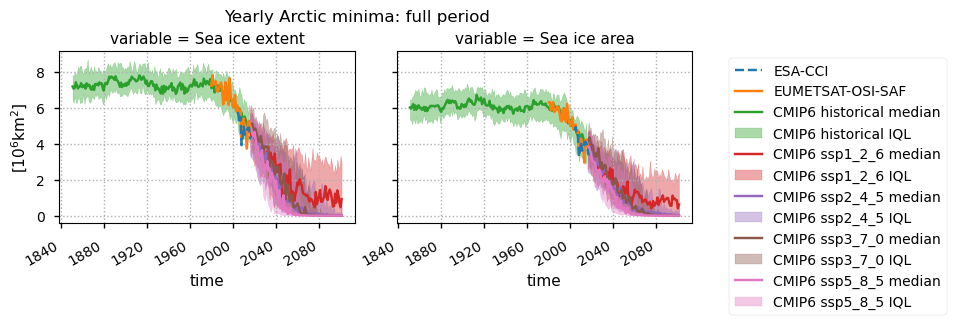

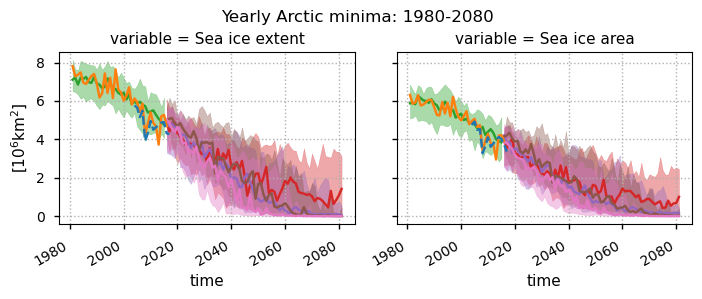

In [22]:
plot_time_series_regional_reduction(
    datasets_satellite, datasets_cmip6, reduction="min", sea_mask="Arctic")

The maps below show the spatial pattern of the decrease in sea ice cover by plotting the ensemble mean of the sea ice concentration for a series of 20-year climatologies. Going from left to right (increasing the amount of warming in the projection), there is quite a big difference, especially from 2035. From 2055 only the `ssp_1_2_6` experiment has a significant amount of ice in September.

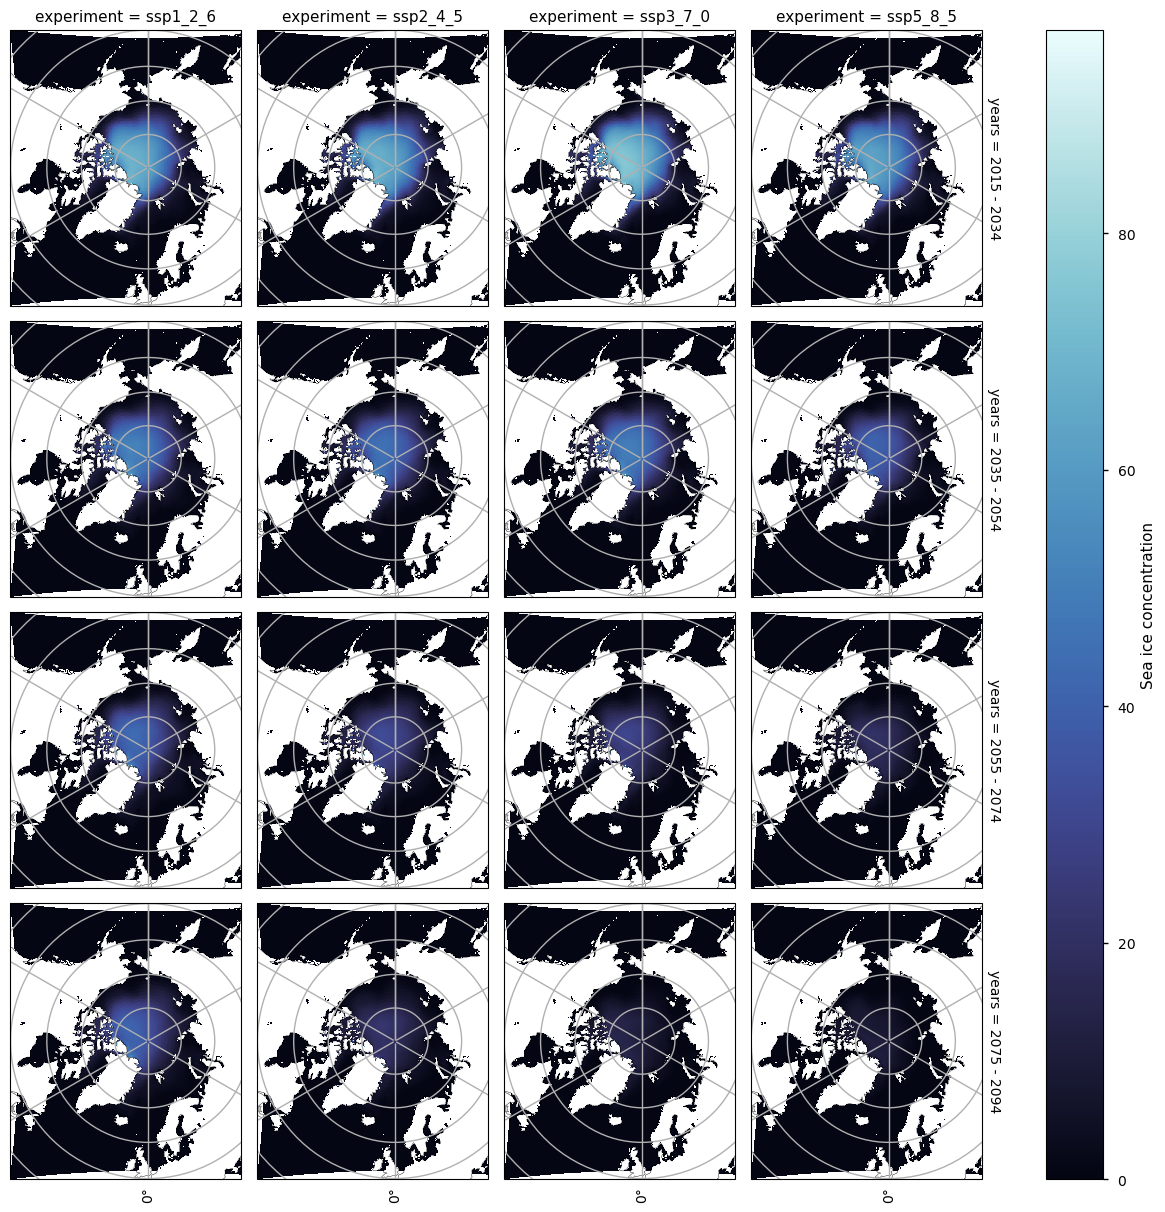

In [23]:
compare_sic_maps(region="Arctic", sel_dict={"month": "September"}, **map_kwargs)

Looking at the chances of the Arctic being ice-free, we can see that for the `ssp1_2_6` experiment, the chances are mostly only about 10-15%, although the time window when this is happening expands from August-September to include July and October by around 2050. Later the probability increases to 20-25% in the month of September.

We can see however that the chances are being overestimated (with perhaps a bias of 10%) since some years in the past (at time of writing i.e. 2015-2023) have 10% chance of the Arctic being ice-free while it has never been observed yet. 

In the `ssp2_4_5` experiment, the results are similar but with the chances of being ice-free increasing to 25% around 2050 to around 50% by 2100. In addition, there is now starting to be a slight chance of being ice free in June and November.

In the `ssp3_7_0` experiment, there are now chances of being ice-free in September of around 80% from about 2080. In August and October, there is also a 50% chance in some of the later years. The chances of being ice free in June and November has now increased.

In the `ssp5_8_5` experiment, there are now chances of being ice-free in August and October of around 70-80% from about 2070. In September, the chances of being ice-free are consistently around 80% from 2080.

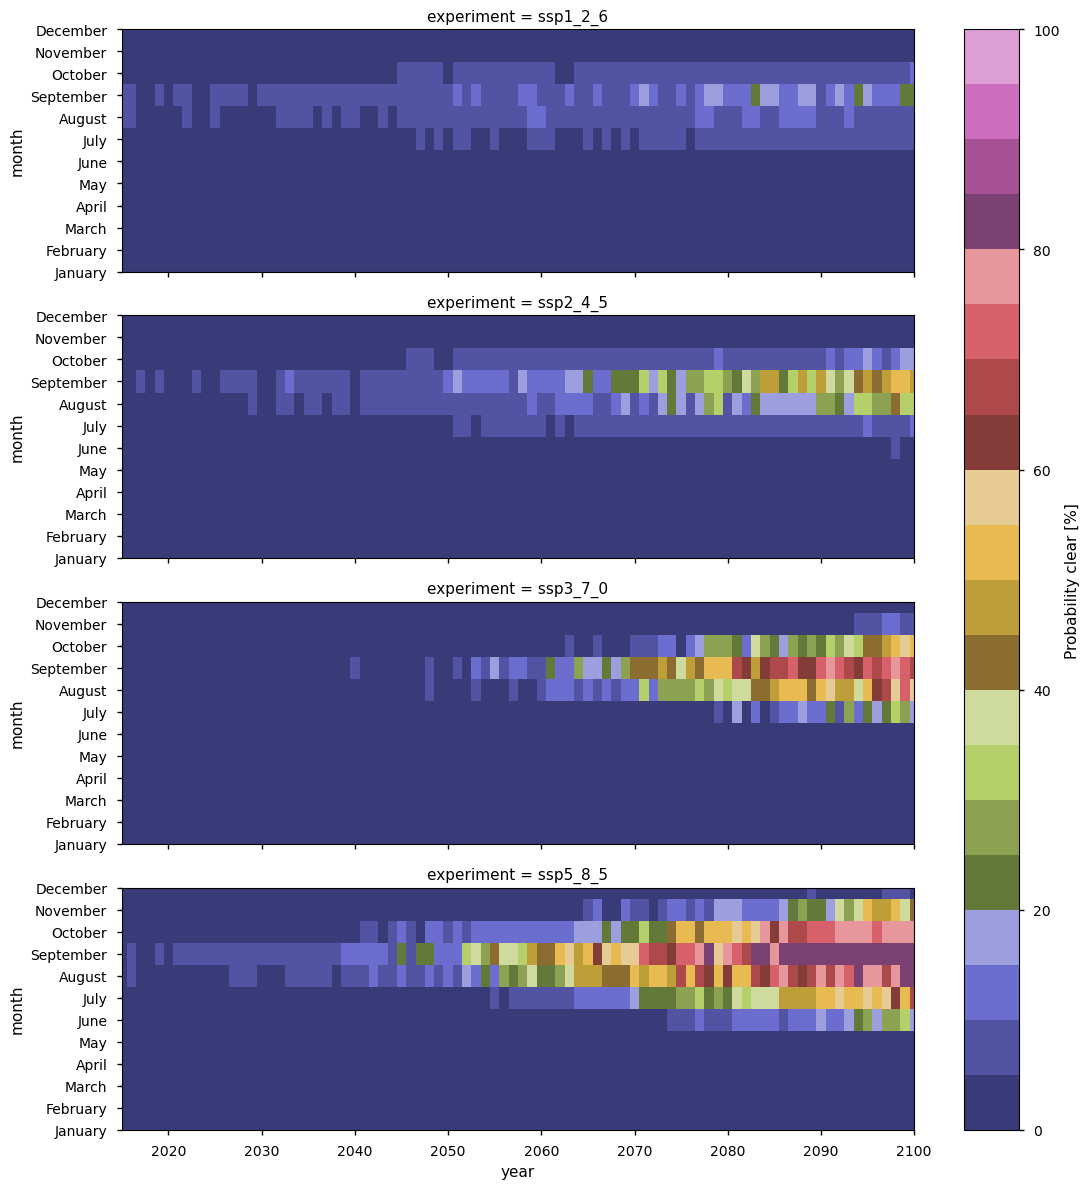

In [24]:
plot_access_tables(datasets_cmip6, "Arctic")

### Arctic sea ice maxima
Like the Arctic minimum in sea ice extent, the maximum sea ice extent is constant until about 1990 the historical CMIP6 is relatively constant, before starting to drop rapidly. However, unlike with the minimum extent, there is a clear bias in this variable, with both the ERA5 reanalysis and the CMIP6 ensembles underestimating it by about $1.5\times10^6$km$^2$. As we come to the start of the projection period (2015-2100), the yearly maxima continues to drop. Unlike with the minima, the maximum sea ice extent shows a clear response to increased warming --- as the warming increases the median Arctic maximum extent drops. The experiment with the most warming (`ssp5_8_5`) also shows a very large spread in this variable by 2100.

The yearly maximum in sea ice area follows mostly the same pattern as the sea ice extent.

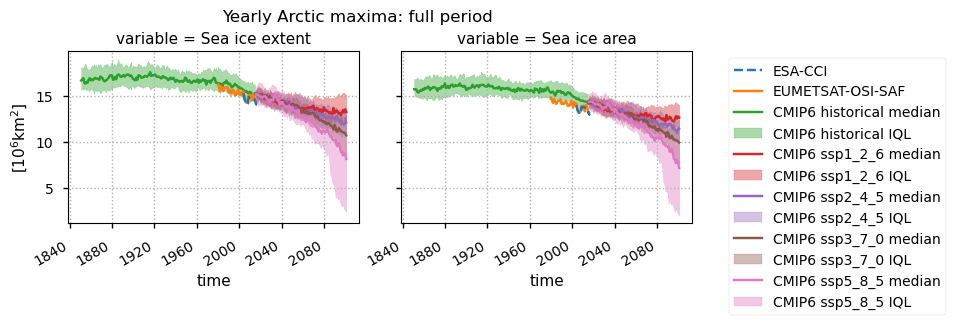

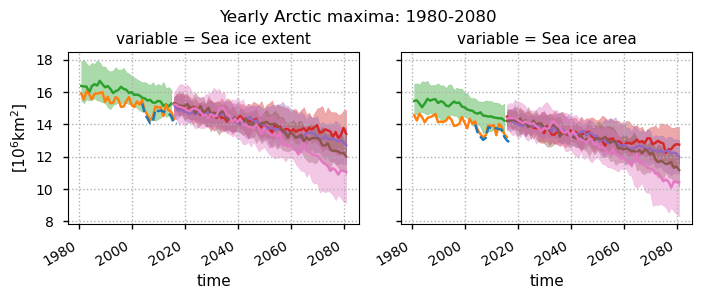

In [25]:
plot_time_series_regional_reduction(
    datasets_satellite, datasets_cmip6, reduction="max", sea_mask="Arctic")

Looking at the maps below, we can see that there is not too much difference between the maps in March before about 2055. After this however, the `ssp5_8_5` experiment especially starts to have reduced concentration in the central Arctic, and also in the Hudson Bay. The `ssp3_7_0` experiment also shows this pattern to some extent. The drop in maximum sea ice extent with time can also be seen, e.g. in the Bering and Labrador Seas.

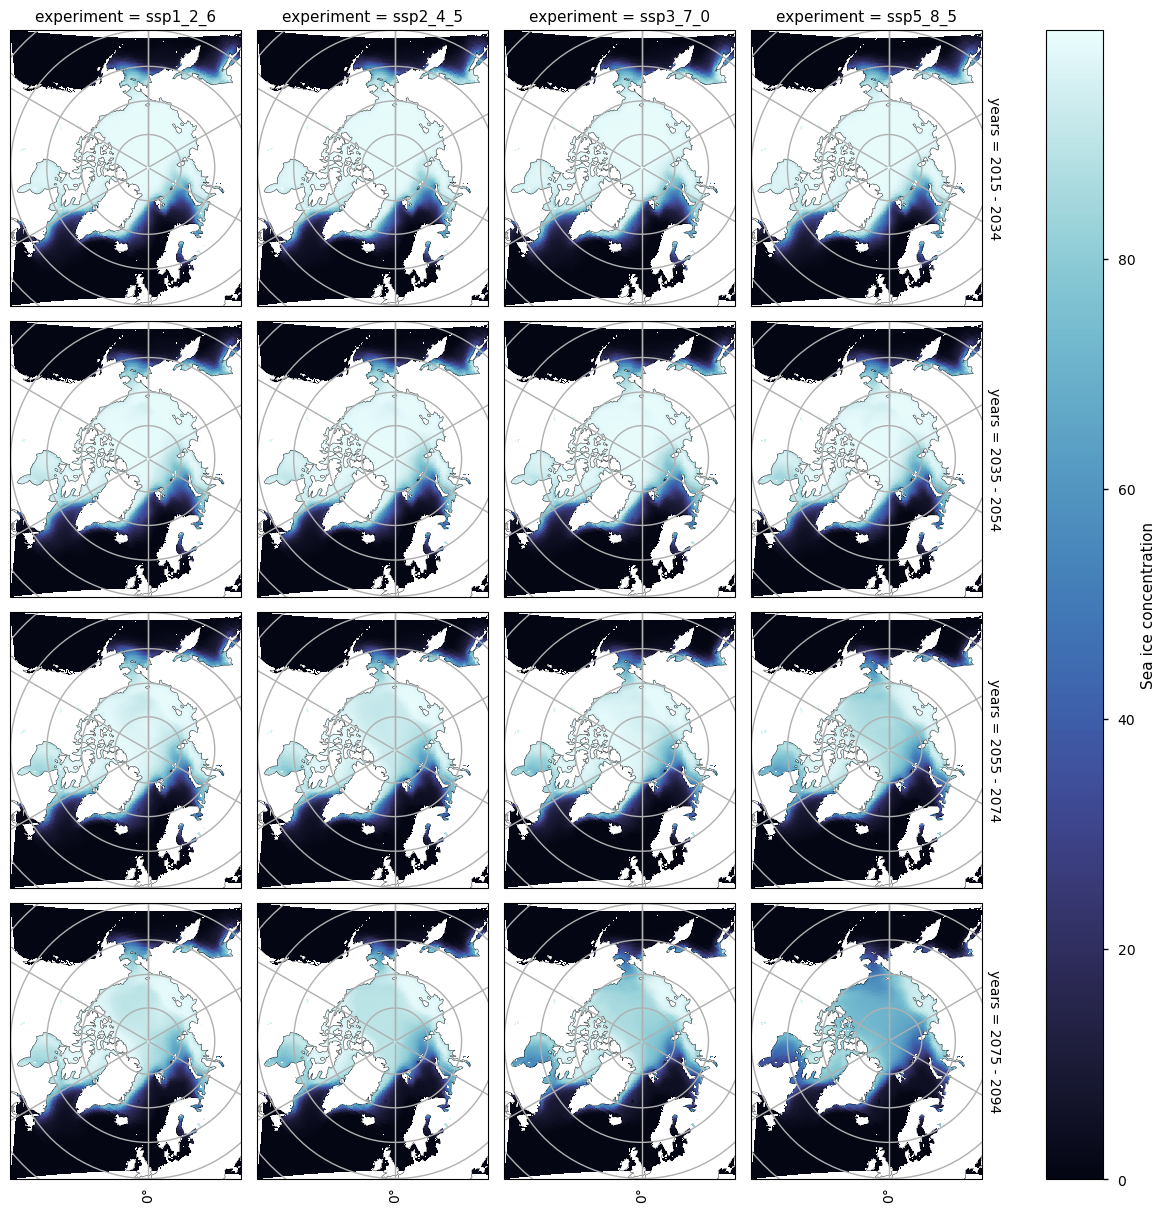

In [26]:
compare_sic_maps(region="Arctic", sel_dict={"month": "March"}, **map_kwargs)

### Antarctic sea ice minima and the projected probabilities of being ice-free around Antarctic
The Antarctic minimum in sea ice extent also shows a clear effect of increased warming, although the pre-1960 level is much lower than in the Arctic ($2\times10^6$km$^2$ compared to $7\times10^6$km$^2$). After about 1960 the CMIP6 ensemble median starts to slowly drop, and then after 2015 the rate depends on the warming scenario. The median never quite reaches zero in the Antarctic however, although the lower quartiles reach zero about 2060.

The CMIP6 models again show a large bias in the Antarctic sea ice extent compared to the satellite data, underestimating it by about 1-$2\times10^6$km$^2$. On the other hand the ERA5 reanalysis is doing quite well. The satellites seem to show a relatively constant minimum sea ice extent, while there is a steady drop predicted by the CMIP6 models in this time period when observations are available (1979-2017).

The yearly minimum in sea ice area follows mostly the same pattern as the minimum sea ice extent.

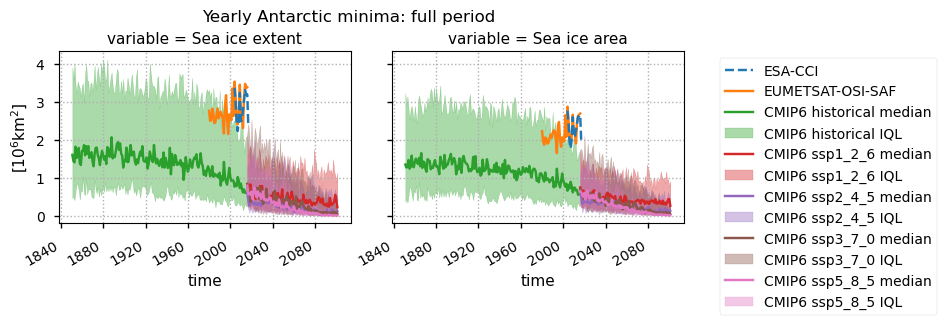

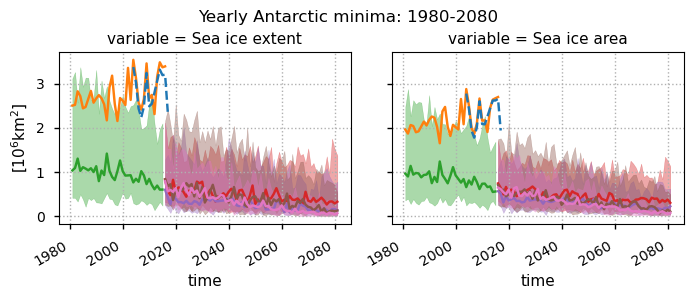

In [27]:
plot_time_series_regional_reduction(
    datasets_satellite, datasets_cmip6, reduction="min", sea_mask="Antarctic")

A clear effect of climate change can be see in the maps below of the Antarctic sea ice concentration for March. Apart from the `ssp1_2_6` experiment, there is very little ice outside the Weddell and Ross Sea, and the `ssp5_8_5` has mostly lost its ice in the Ross Sea by 2075.

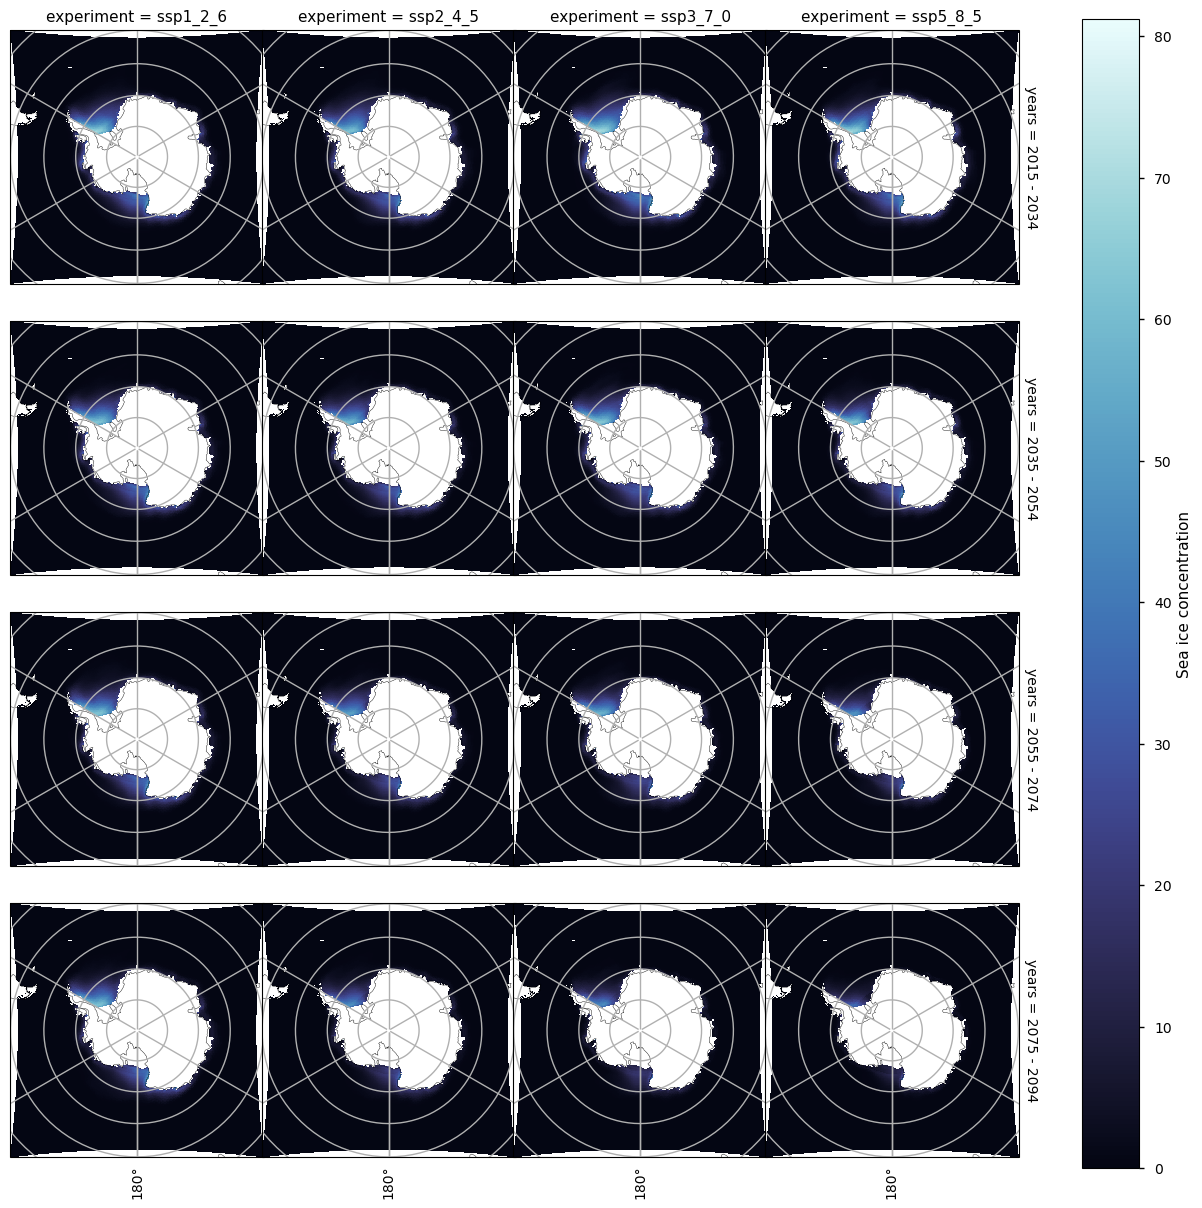

In [28]:
compare_sic_maps(region="Antarctic", sel_dict={"month": "March"}, **map_kwargs)

Compared to the Arctic, the Antarctic region has lower chance of being ice-free, only getting consistently over 50% in the warmest scenario `ssp5_8_5`. The chances reach 80% around 2090 in this experiment. December and April are rarely projected to be ice-free - only in `ssp5_8_5` and only occasionally with a chance of 10%.

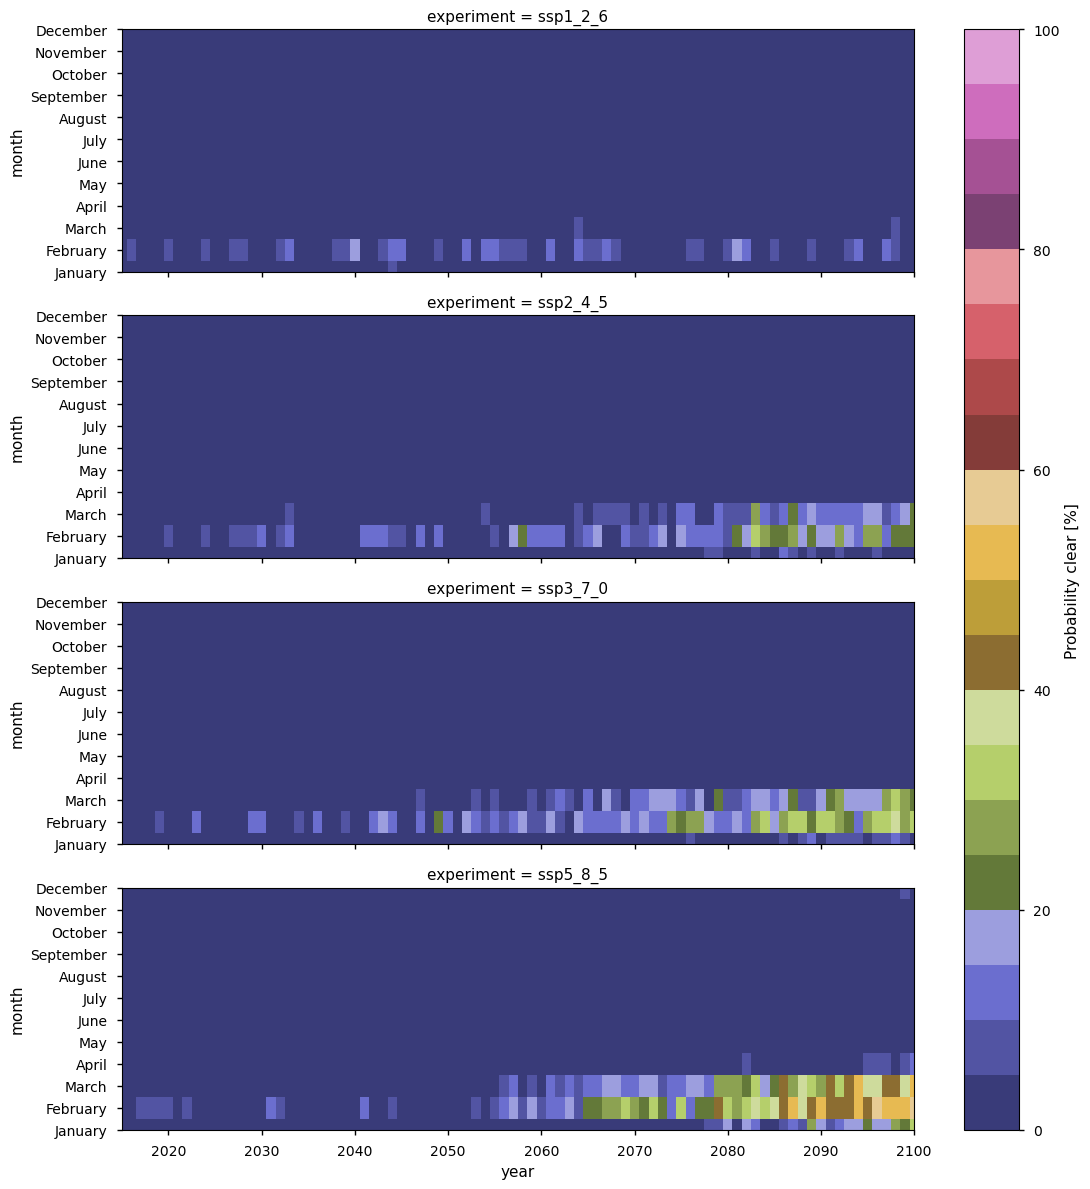

In [29]:
plot_access_tables(datasets_cmip6, "Antarctic")

### Antarctic sea ice maxima
The Antarctic sea ice maxima behave in a similar way to the Arctic maxima with time and warming although the pre-1960 maximum extent is much higher than in the Arctic ($18\times10^6$km$^2$ compared to $15\times10^6$km$^2$). The CMIP6 models again show a large bias in the Antarctic sea ice extent compared to the satellite data, although the difference is less at the start of the start of the satellite period (1979). However, since the satellites show a slight increase in minimum extent, while there is a steady drop predicted by the CMIP6 models, the difference increases with time, reaching about $2\times10^6$km$^2$ by 2015.

As with the Antarctic minimum extent, the ERA5 reanalysis is again agreeing quite well with the satellite data.

The yearly maxima in sea ice area follows mostly the same pattern as for the extent.

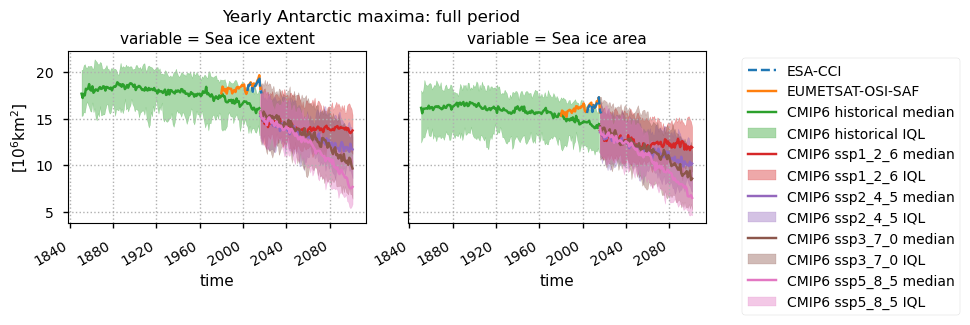

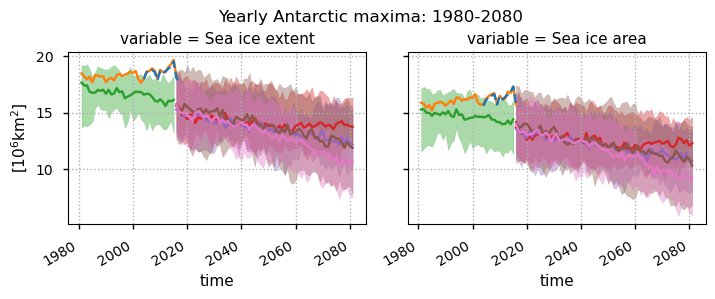

In [30]:
plot_time_series_regional_reduction(
    datasets_satellite, datasets_cmip6, reduction="max", sea_mask="Antarctic")

Less effect can be seen in the maps below of the ensemble mean Antarctic sea ice concentration in September (than for March). A small decrease in extent which is relatively even around the continent is visible though.

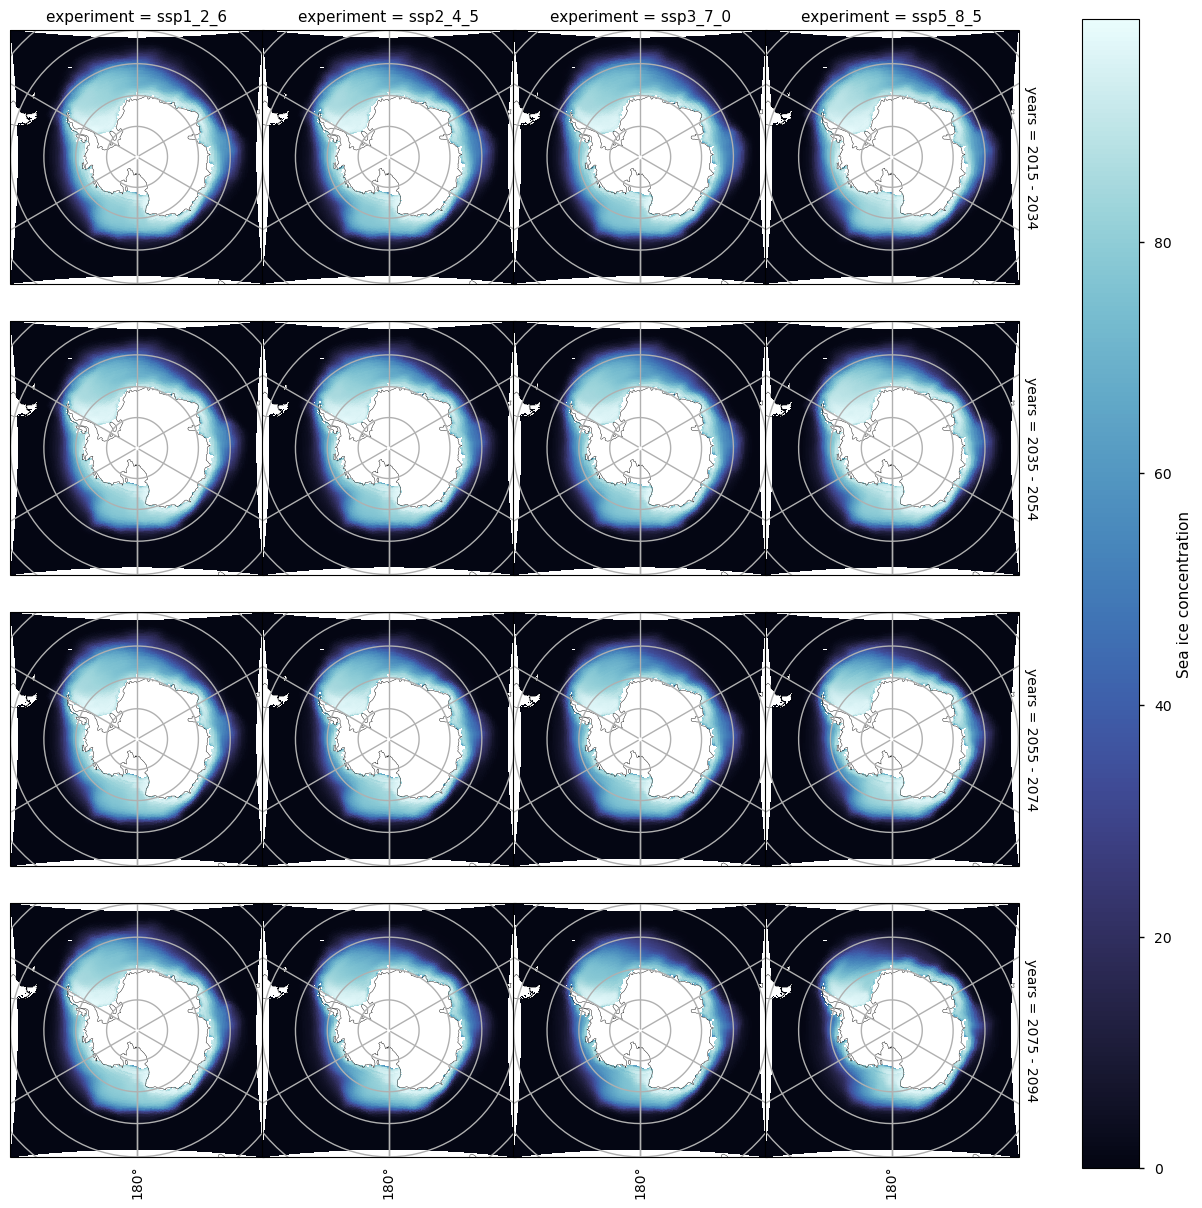

In [31]:
compare_sic_maps(region="Antarctic", sel_dict={"month": "September"}, **map_kwargs)

# Projected access to Arctic shipping routes
We consider two Arctic shipping routes, the Transpolar Shipping Route and the Northern Sea Route. We do not consider the Northwest Passage since the climate models generally don't have enough resolution to represent the Canadian archipelago. The general approach to this problem (eg Melia et al, 2016) is to take ice conditions from a model, and find the optimal ship route between the Bering Sea and the Greenland Sea. Considerations such as the ice class of the vessel may also be taken into account. The route is then classified as the Transpolar Shipping Route or the Northern Sea Route. However, this approach is computationally quite costly so here we have defined simple masks (shown below) that roughly correspond to these two shipping routes, and if the sea ice extent is low enough inside these masks we consider the routes accessible according to a given model. Considering an ensemble of models we can take the percentage of models predicting an area to be ice-free to be the probability that it is ice-free.

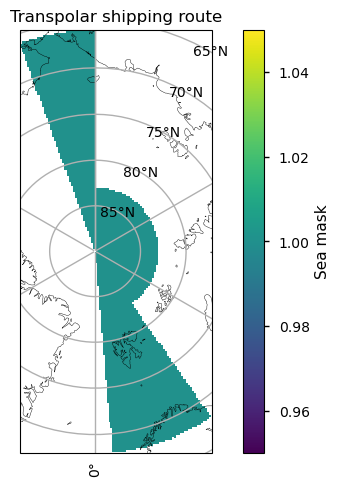

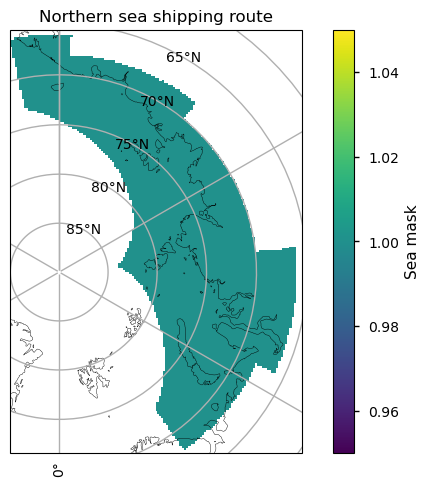

In [32]:
plot_sea_masks()

## Northern sea route
We can see even in the experiment with the least warming, there is a high chance of the Northern Sea Route (NSR) being clear in September, especially after about 2050.
August and October have quite high probabilities also.
The chances increase as the experiments change to produce more warming, and the chances of having the NSR clear in November and July start to increase as well.
The experiment `ssp5_8_5` even has 25-30% chance of it being clear in December in later years, and 95-100% of the models are projecting the NSR to be free in September, October and even August for some years under this scenario .

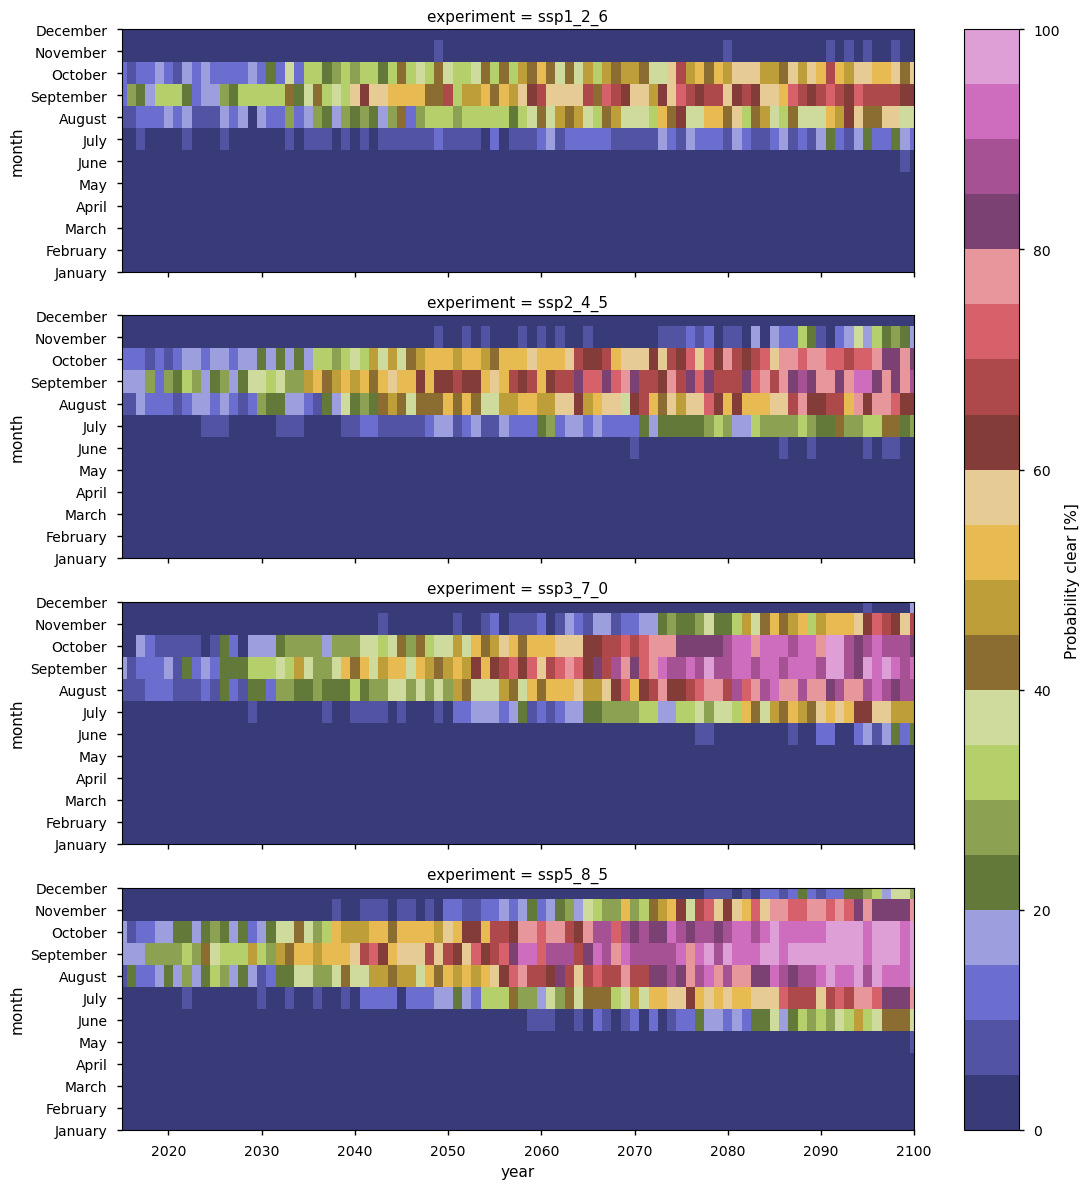

In [33]:
plot_access_tables(datasets_cmip6, "Northern Sea Shipping Route")

## Transpolar shipping route
The Transpolar shipping route (TSR) has slightly lower chances of being ice-free in the months August-October (than the NSR) but somewhat surprisingly it is a bit higher in other months, with it having some chance of it being clear in winter months in the experiments with higher warming. The maps below plot the ensemble mean sea ice concentration for December for a series of time intervals between 2015 and 2085. In the 2075-2095 period, the `ssp5_8_5` has a distinct gap where we have defined our TSR, while there is still ice off the Russian coast blocking the NSR. The effect is also present to a lesser extent for the `ssp2_4_5` and `ssp3_7_0` experiments, so perhaps ice-strengthened vessels could still traverse the TSR under these scenarios also.

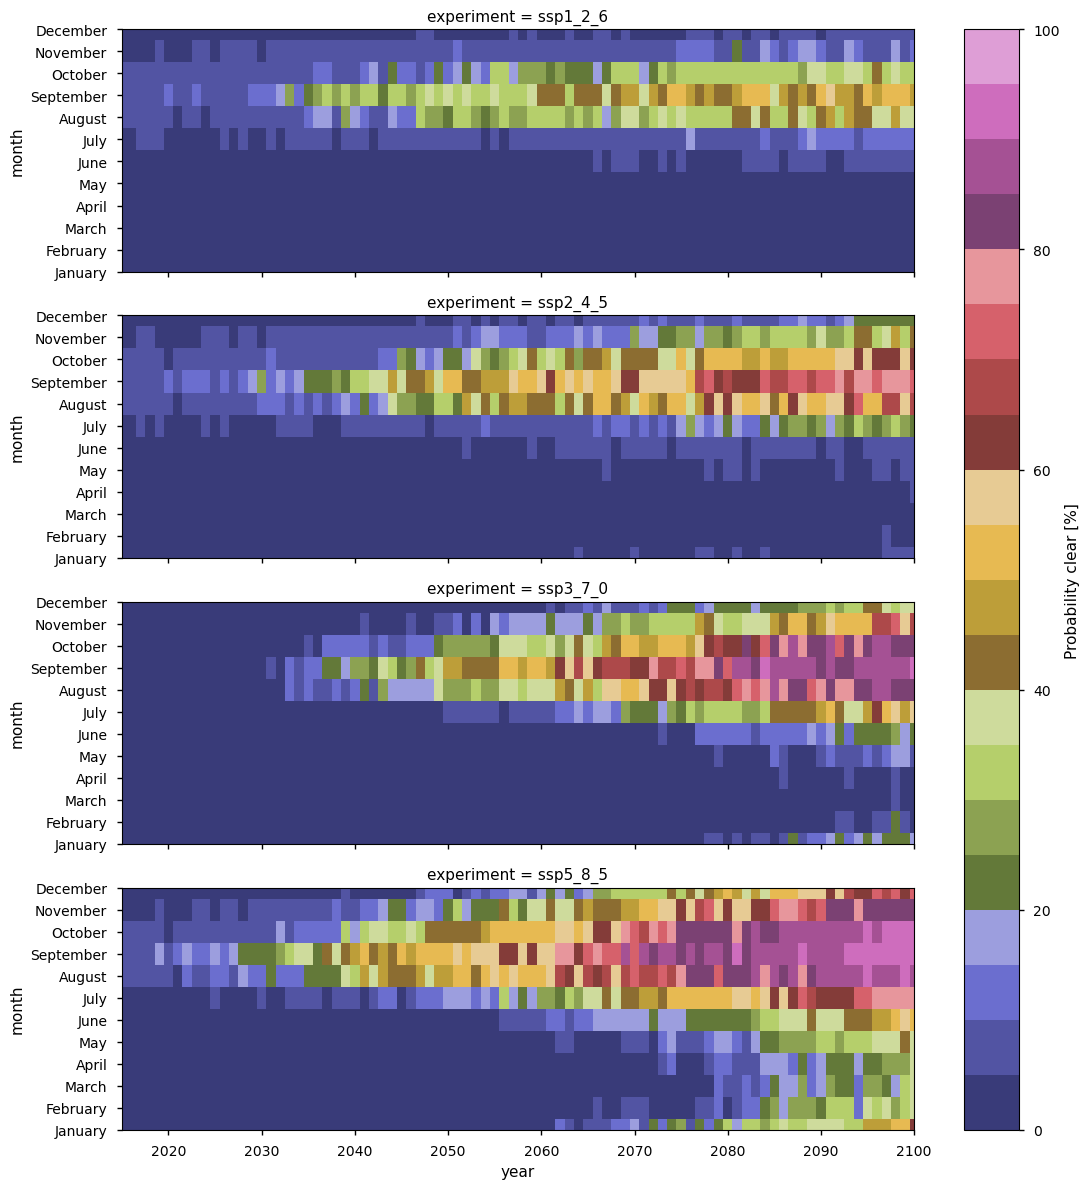

In [34]:
plot_access_tables(datasets_cmip6, "Transpolar Shipping Route")

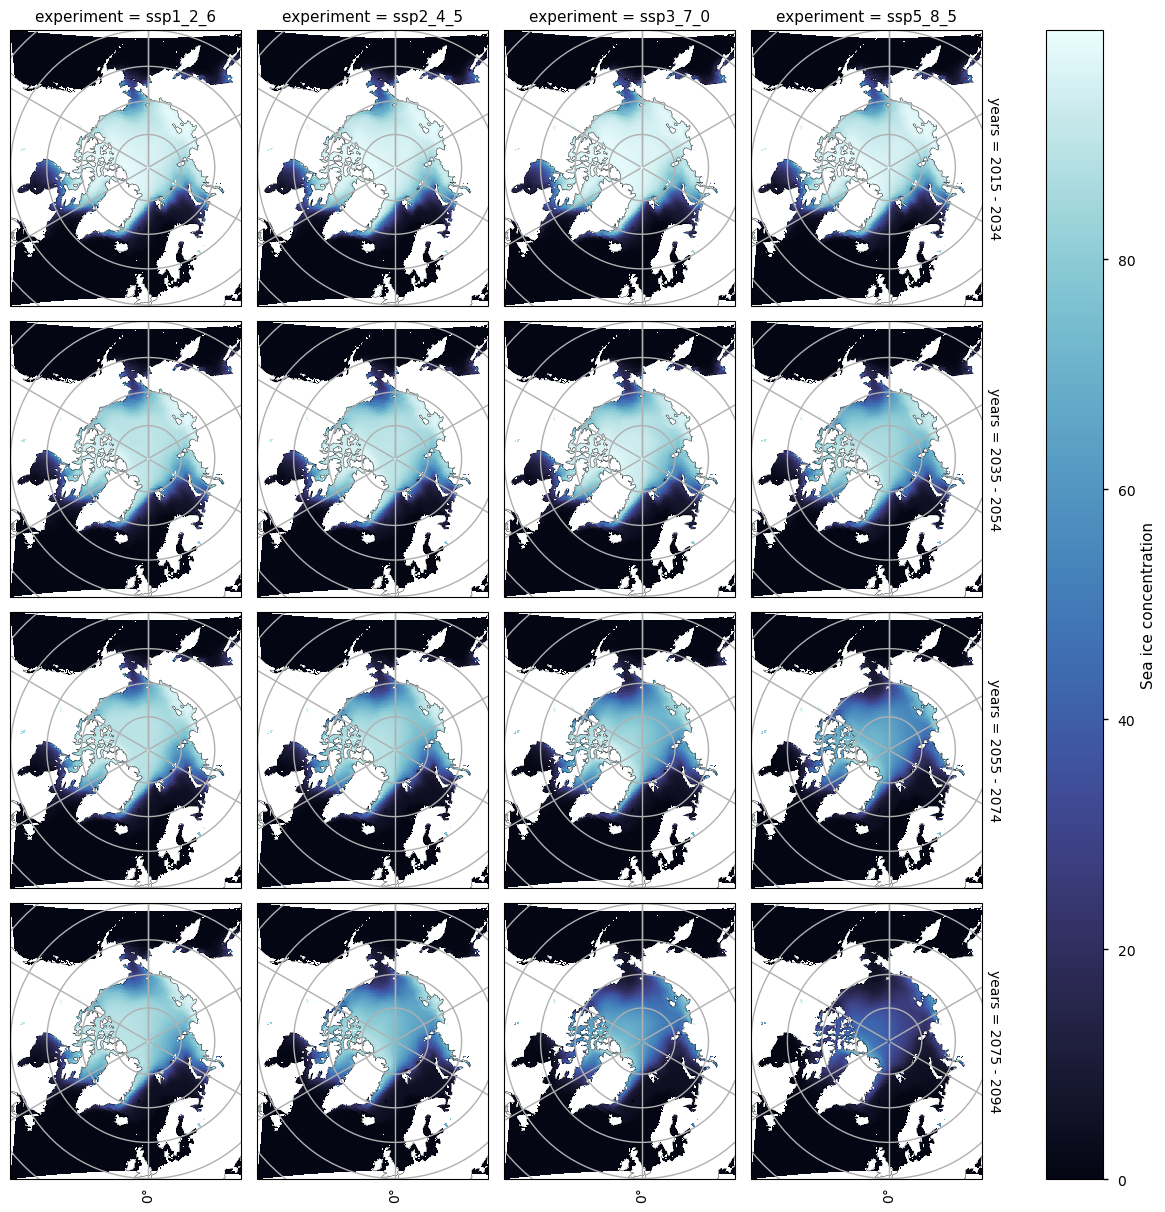

In [35]:
compare_sic_maps(region="Arctic", sel_dict={"month": "December"}, **map_kwargs)

## References
Melia, N., Haines, K., and Hawkins, E. (2016), Sea ice decline and 21st century trans-Arctic shipping routes, Geophys. Res. Lett., 43, 9720–9728, doi:10.1002/2016GL069315.